### Ambiente de Desenvolvimento

- **Notebook:** Alienware M15 R6  
- **IDE:** Visual Studio Code  
    - Extensão: [Data Wrangler](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler) para visualização facilitada dos dados, evitando o uso excessivo de `print`.
- **SO:** Windows 11  
    - **Ambiente de Programação:** WSL2 Arch Linux  

### Workspace

python -m venv .venv  
ativação do ambiente:  
- Linux/Mac: `source .venv/bin/activate`  

Bibliotecas utilizadas
- `pip install pandas` 
- `pip install pyarrow`   
- `pip install fastparquet`   
- `pip install polars` 
- `pip install scikit-learn` 

---

---

# 1 - ETL (Extract, transform, load)

Verifico o inicio e o fim do dataframe, uma visualização rápida. Verifico seu tamanho, quantas linhas e colunas e visualizo suas informações com .info(), aqui já tenho o dtype de suas colunas e se há valores nulos. Verifico se há duplicadas em case_id e também a contabilidade total de target, construindo uma funcao generica para visualizar a distribuição percentual de target entre 0 e 1.  
  
1.1 - Transformações:  
Visualizo que os dypes estão errados, considerando case_id, month, week_num e target como int. Modificos para str, e em date_decision, transformo em datetime, isso ajudará futuramente no modelo preditivo.

Bibliotecas utilizadas

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

## 1.1 - Lendo o arquivo base

In [2]:
df_train_base = pl.read_parquet('../parquet_files/train/train_base.parquet')

In [3]:
def agrupamentos(df, column):
    agrupados = (df[column].value_counts(sort=True).with_columns((pl.col('count') / pl.col('count').sum() * 100).round(2).alias('%')))
    return agrupados

agrupamentos(df_train_base, 'target')

target,count,%
i64,u32,f64
0,1478665,96.86
1,47994,3.14


---

## 1.2 -  Incorporando outras bases

### 1.2.1 - Bases Internas

In [4]:
df_train_static = pl.read_parquet('../parquet_files/train/train_static_0_0.parquet').vstack(pl.read_parquet('../parquet_files/train/train_static_0_1.parquet'))

### 1.2.2 -  Base Externa

In [5]:
df_train_static_cb_0 = pl.read_parquet('../parquet_files/train/train_static_cb_0.parquet')

## 1.3 - Selecionando as variáveis

### Seleção das Principais Variáveis

A seleção das variáveis foi guiada pela teoria clássica de risco de crédito (modelos FICO, 5 C’s do crédito e literatura bancária), priorizando fatores reconhecidamente relevantes para previsão de inadimplência. As variáveis estão agrupadas por temas, com explicação do papel de cada grupo na análise.

### 1. Histórico de Pagamento (mais importante)

Variáveis que capturam o comportamento passado do cliente em relação a atrasos e inadimplência, reconhecidamente o fator mais relevante para previsão de risco.

- **maxdpdlast24m_143P, maxdpdlast12m_727P, maxdpdlast6m_474P, maxdpdlast3m_392P**: Máximo de dias em atraso nos últimos 24, 12, 6 e 3 meses, respectivamente.
- **pctinstlsallpaidlate1d_3546856L, pctinstlsallpaidlate4d_3546849L**: Percentual de parcelas pagas com atraso de 1+ e 4+ dias.
- **avgdbddpdlast24m_3658932P**: Média de dias antes ou após o vencimento das parcelas nos últimos 24 meses.
- **datelastunpaid_3546854D**: Data da última parcela não paga.

### 2. Capacidade de Pagamento

Variáveis que avaliam se o cliente tem condições financeiras de arcar com o compromisso assumido.

- **annuity_780A**: Valor da anuidade mensal do contrato.
- **maininc_215A**: Renda principal do cliente.
- **currdebt_22A**: Dívida atual do cliente.
- **avgpmtlast12m_4525200A**: Média dos pagamentos realizados nos últimos 12 meses.
- **maxannuity_159A**: Maior valor de anuidade registrado.

### 3. Utilização de Crédito e Endividamento

Variáveis que medem o quanto do limite de crédito o cliente já está utilizando e seu nível de endividamento.

- **credamount_770A**: Valor do crédito contratado.
- **currdebtcredtyperange_828A**: Dívida atual por tipo de crédito.
- **disbursedcredamount_1113A**: Valor do crédito efetivamente desembolsado.
- **maxdebt4_972A**: Máximo valor de dívida registrado.
- **avginstallast24m_3658937A**: Média do valor das parcelas nos últimos 24 meses.

### 4. Histórico e Relacionamento

Variáveis que indicam estabilidade e experiência do cliente com crédito.

- **numactivecreds_622L**: Número de créditos ativos atualmente.
- **numcontrs3months_479L**: Número de contratos firmados nos últimos 3 meses.
- **lastapprdate_640D**: Data da última aprovação de crédito.
- **lastrepayingdate_696D**: Data do último pagamento realizado.

### 5. Consultas e Aplicações Recentes

Variáveis que indicam busca recente por crédito, o que pode sinalizar aumento de risco.

- **days30_165L, days90_310L**: Consultas ao bureau nos últimos 30 e 90 dias.
- **applications30d_658L**: Aplicações para crédito nos últimos 30 dias.
- **numrejects9m_859L**: Número de rejeições de crédito nos últimos 9 meses.
- **applicationscnt_1086L**: Número de aplicações feitas com o mesmo telefone.

### 6. Scores e Avaliações de Risco

Variáveis que trazem avaliações quantitativas do risco de inadimplência.

- **riskassesment_302T**: Avaliação de risco (probabilidade de default).
- **riskassesment_940T**: Estimativa de creditworthiness.

### 7. Variáveis Categóricas Importantes

Variáveis qualitativas que podem capturar padrões de risco específicos de segmentos, regiões ou produtos.

- **education_1103M**: Escolaridade do cliente.
- **maritalst_385M**: Estado civil.
- **lastcancelreason_561M**: Razão do último cancelamento.
- **lastrejectreason_759M**: Razão da última rejeição.

### 8. Comportamento de Pagamento Detalhado

Variáveis que detalham o comportamento de pagamento do cliente.

- **numinstpaidlate1d_3546852L**: Número de parcelas pagas com 1+ dia de atraso.
- **numinstlsallpaid_934L**: Número total de parcelas pagas.
- **numinstlswithoutdpd_562L**: Parcelas pagas sem atraso.
- **pctinstlsallpaidearl3d_427L**: Percentual de parcelas pagas 3+ dias antes do vencimento.

### 9. Informações Complementares

Variáveis adicionais que podem indicar risco ou fraude.

- **mobilephncnt_593L**: Contagem de telefones móveis associados ao cliente.
- **homephncnt_628L**: Contagem de telefones residenciais.
- **clientscnt12m_3712952L**: Número de clientes com o mesmo telefone nos últimos 12 meses.
- **equalitydataagreement_891L**: Indica se o cliente aceitou o acordo de dados de igualdade.

In [6]:
def selecionar_variaveis_principais(df):
    """
    Seleciona as principais variáveis para análise de risco de crédito
    baseadas na teoria financeira e disponíveis nos datasets.
    """
    
    variaveis_principais = ['maxdpdlast24m_143P', 'maxdpdlast12m_727P', 'maxdpdlast6m_474P', 'maxdpdlast3m_392P', 'pctinstlsallpaidlate1d_3546856L', 'pctinstlsallpaidlate4d_3546849L', 'avgdbddpdlast24m_3658932P', 'datelastunpaid_3546854D', 'annuity_780A', 'maininc_215A', 'currdebt_22A', 'avgpmtlast12m_4525200A', 'maxannuity_159A', 'credamount_770A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'maxdebt4_972A', 'avginstallast24m_3658937A', 'numactivecreds_622L', 'numcontrs3months_479L', 'lastapprdate_640D', 'lastrepayingdate_696D', 'days30_165L', 'days90_310L', 'applications30d_658L', 'numrejects9m_859L', 'applicationscnt_1086L', 'riskassesment_302T', 'riskassesment_940T', 'education_1103M', 'maritalst_385M', 'lastcancelreason_561M', 'lastrejectreason_759M', 'numinstpaidlate1d_3546852L', 'numinstlsallpaid_934L', 'numinstlswithoutdpd_562L', 'pctinstlsallpaidearl3d_427L', 'mobilephncnt_593L', 'homephncnt_628L', 'clientscnt12m_3712952L', 'equalitydataagreement_891L']
    
    colunas_existentes = [col for col in variaveis_principais if col in df.columns]
    
    if 'case_id' in df.columns and 'case_id' not in colunas_existentes:
        colunas_existentes = ['case_id'] + colunas_existentes
    
    return df[colunas_existentes]

In [7]:
df_train_static_principais = selecionar_variaveis_principais(df_train_static)
df_train_static_cb_principais = selecionar_variaveis_principais(df_train_static_cb_0)

df_train_base = df_train_base.with_columns(pl.col('case_id').cast(pl.Utf8))
df_train_static_principais = df_train_static_principais.with_columns(pl.col('case_id').cast(pl.Utf8))
df_train_static_cb_principais = df_train_static_cb_principais.with_columns(pl.col('case_id').cast(pl.Utf8))

df_train_model = (df_train_base.join(df_train_static_principais, on='case_id', how='left').join(df_train_static_cb_principais, on='case_id', how='left'))

In [8]:
df_train_model['credamount_770A'].sum()

76134728341.7408

In [9]:
df_train_model = df_train_model.sample(n=300_000)

## 1.4 - Visualizando Colunas

In [10]:
df_train_model.columns

['case_id',
 'date_decision',
 'MONTH',
 'WEEK_NUM',
 'target',
 'maxdpdlast24m_143P',
 'maxdpdlast12m_727P',
 'maxdpdlast6m_474P',
 'maxdpdlast3m_392P',
 'pctinstlsallpaidlate1d_3546856L',
 'pctinstlsallpaidlate4d_3546849L',
 'avgdbddpdlast24m_3658932P',
 'datelastunpaid_3546854D',
 'annuity_780A',
 'maininc_215A',
 'currdebt_22A',
 'avgpmtlast12m_4525200A',
 'maxannuity_159A',
 'credamount_770A',
 'currdebtcredtyperange_828A',
 'disbursedcredamount_1113A',
 'maxdebt4_972A',
 'avginstallast24m_3658937A',
 'numactivecreds_622L',
 'numcontrs3months_479L',
 'lastapprdate_640D',
 'lastrepayingdate_696D',
 'applications30d_658L',
 'numrejects9m_859L',
 'applicationscnt_1086L',
 'lastcancelreason_561M',
 'lastrejectreason_759M',
 'numinstpaidlate1d_3546852L',
 'numinstlsallpaid_934L',
 'numinstlswithoutdpd_562L',
 'pctinstlsallpaidearl3d_427L',
 'mobilephncnt_593L',
 'homephncnt_628L',
 'clientscnt12m_3712952L',
 'equalitydataagreement_891L',
 'days30_165L',
 'days90_310L',
 'riskassesment_

In [11]:
print(f"Antes - {df_train_base.shape}")
print(f"Depois - {df_train_model.shape}")

Antes - (1526659, 5)
Depois - (300000, 46)


In [12]:
df_train_model.head()

case_id,date_decision,MONTH,WEEK_NUM,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,datelastunpaid_3546854D,annuity_780A,maininc_215A,currdebt_22A,avgpmtlast12m_4525200A,maxannuity_159A,credamount_770A,currdebtcredtyperange_828A,disbursedcredamount_1113A,maxdebt4_972A,avginstallast24m_3658937A,numactivecreds_622L,numcontrs3months_479L,lastapprdate_640D,lastrepayingdate_696D,applications30d_658L,numrejects9m_859L,applicationscnt_1086L,lastcancelreason_561M,lastrejectreason_759M,numinstpaidlate1d_3546852L,numinstlsallpaid_934L,numinstlswithoutdpd_562L,pctinstlsallpaidearl3d_427L,mobilephncnt_593L,homephncnt_628L,clientscnt12m_3712952L,equalitydataagreement_891L,days30_165L,days90_310L,riskassesment_302T,riskassesment_940T,education_1103M,maritalst_385M
str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,bool,f64,f64,str,f64,str,str
"""927416""","""2020-01-05""",202001,52,0,0.0,0.0,0.0,0.0,null,null,null,null,2394.8,null,0.0,null,0.0,11596.0,0.0,11596.0,0.0,null,0.0,1.0,null,null,0.0,1.0,0.0,"""P94_109_143""","""P45_84_106""",null,null,null,null,2.0,1.0,0.0,null,0.0,3.0,null,null,"""a55475b1""","""a55475b1"""
"""1654713""","""2019-11-29""",201911,47,0,5.0,5.0,0.0,0.0,0.66667,0.16667,1.0,"""2019-05-09""",3666.6,30000.0,0.0,2329.0,4700.0,43998.0,0.0,43998.0,22708.0,2329.0,0.0,0.0,"""2018-06-08""",null,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",8.0,4.0,5.0,0.08333,1.0,0.0,0.0,null,0.0,0.0,null,null,"""a55475b1""","""a55475b1"""
"""1324157""","""2019-03-29""",201903,12,0,3.0,3.0,0.0,0.0,0.1875,0.12766,-40.0,"""2018-08-11""",1333.6,34000.0,29380.4,null,14527.601,15996.0,0.0,15996.0,49322.57,2277.6,2.0,0.0,"""2018-11-15""",null,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",9.0,39.0,41.0,0.66667,3.0,1.0,0.0,null,0.0,0.0,null,null,"""6b2ae0fa""","""3439d993"""
"""2530188""","""2019-01-04""",201901,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,null,5600.6,69600.0,0.0,null,19099.154,90000.0,0.0,90000.0,45415.574,4730.4,2.0,1.0,"""2018-11-04""",null,0.0,4.0,0.0,"""a55475b1""","""P94_109_143""",0.0,15.0,37.0,1.0,2.0,1.0,0.0,null,null,null,null,null,null,null
"""1868496""","""2020-06-21""",202006,76,0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,null,2782.0,160000.0,121302.0,6387.8003,6420.0,39240.0,0.0,39240.0,100000.0,6387.8003,1.0,0.0,"""2020-01-29""",null,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",0.0,5.0,5.0,1.0,1.0,0.0,0.0,null,1.0,1.0,null,null,"""a55475b1""","""a55475b1"""


In [13]:
df_train_model['case_id'].is_duplicated().sum()

0

In [14]:
df_train_model.schema

Schema([('case_id', String),
        ('date_decision', String),
        ('MONTH', Int64),
        ('WEEK_NUM', Int64),
        ('target', Int64),
        ('maxdpdlast24m_143P', Float64),
        ('maxdpdlast12m_727P', Float64),
        ('maxdpdlast6m_474P', Float64),
        ('maxdpdlast3m_392P', Float64),
        ('pctinstlsallpaidlate1d_3546856L', Float64),
        ('pctinstlsallpaidlate4d_3546849L', Float64),
        ('avgdbddpdlast24m_3658932P', Float64),
        ('datelastunpaid_3546854D', String),
        ('annuity_780A', Float64),
        ('maininc_215A', Float64),
        ('currdebt_22A', Float64),
        ('avgpmtlast12m_4525200A', Float64),
        ('maxannuity_159A', Float64),
        ('credamount_770A', Float64),
        ('currdebtcredtyperange_828A', Float64),
        ('disbursedcredamount_1113A', Float64),
        ('maxdebt4_972A', Float64),
        ('avginstallast24m_3658937A', Float64),
        ('numactivecreds_622L', Float64),
        ('numcontrs3months_479L', Float64)

In [15]:
for f in df_train_model.columns:
    print(f, ' --> ', df_train_model[f].value_counts().shape[0])

case_id  -->  300000
date_decision  -->  643
MONTH  -->  22
WEEK_NUM  -->  92
target  -->  2
maxdpdlast24m_143P  -->  2290
maxdpdlast12m_727P  -->  1747
maxdpdlast6m_474P  -->  1195
maxdpdlast3m_392P  -->  807
pctinstlsallpaidlate1d_3546856L  -->  4811
pctinstlsallpaidlate4d_3546849L  -->  3990
avgdbddpdlast24m_3658932P  -->  2690
datelastunpaid_3546854D  -->  5057
annuity_780A  -->  51471
maininc_215A  -->  2884
currdebt_22A  -->  90575
avgpmtlast12m_4525200A  -->  49151
maxannuity_159A  -->  97267
credamount_770A  -->  65220
currdebtcredtyperange_828A  -->  57157
disbursedcredamount_1113A  -->  67931
maxdebt4_972A  -->  118756
avginstallast24m_3658937A  -->  57434
numactivecreds_622L  -->  8
numcontrs3months_479L  -->  34
lastapprdate_640D  -->  5189
lastrepayingdate_696D  -->  266
applications30d_658L  -->  22
numrejects9m_859L  -->  46
applicationscnt_1086L  -->  86
lastcancelreason_561M  -->  61
lastrejectreason_759M  -->  17
numinstpaidlate1d_3546852L  -->  103
numinstlsallpaid_9

In [16]:
df_train_model.null_count()

case_id,date_decision,MONTH,WEEK_NUM,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,datelastunpaid_3546854D,annuity_780A,maininc_215A,currdebt_22A,avgpmtlast12m_4525200A,maxannuity_159A,credamount_770A,currdebtcredtyperange_828A,disbursedcredamount_1113A,maxdebt4_972A,avginstallast24m_3658937A,numactivecreds_622L,numcontrs3months_479L,lastapprdate_640D,lastrepayingdate_696D,applications30d_658L,numrejects9m_859L,applicationscnt_1086L,lastcancelreason_561M,lastrejectreason_759M,numinstpaidlate1d_3546852L,numinstlsallpaid_934L,numinstlswithoutdpd_562L,pctinstlsallpaidearl3d_427L,mobilephncnt_593L,homephncnt_628L,clientscnt12m_3712952L,equalitydataagreement_891L,days30_165L,days90_310L,riskassesment_302T,riskassesment_940T,education_1103M,maritalst_385M
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,60156,60156,60156,60156,90297,90491,120803,174691,0,100680,0,201939,60156,0,0,0,60156,123101,0,0,87010,299555,0,0,0,0,0,89095,87748,89831,90297,0,0,0,284652,27708,27708,289353,289353,5087,5087


### 1.4.1 - Análise de Multicolinearidade

In [17]:
df_train_model.shape

(300000, 46)

In [18]:
colunas_a = [col for col in df_train_model.columns if col.endswith('A')]
corr_matrix = df_train_model.select(colunas_a).to_pandas().corr(method='pearson').abs()
acima = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

In [19]:
limite = 0.8
pares_correlacionados = (
    acima.stack()
    .reset_index()
    .rename(columns={0: 'correlação', 'level_0': 'variável_1', 'level_1': 'variável_2'})
    .query('correlação > @limite')
    .sort_values(by='correlação', ascending=False)
)

if not pares_correlacionados.empty:
    print(f"\nPares de variáveis com correlação acima de {limite}:")
    for _, row in pares_correlacionados.iterrows():
        print(f"{row['variável_1']} x {row['variável_2']} -> correlação: {row['correlação']:.2f}")
else:
    print(f"\nNenhum par de variáveis com correlação acima de {limite}.")


Pares de variáveis com correlação acima de 0.8:
credamount_770A x disbursedcredamount_1113A -> correlação: 0.93
avgpmtlast12m_4525200A x avginstallast24m_3658937A -> correlação: 0.83
annuity_780A x credamount_770A -> correlação: 0.82


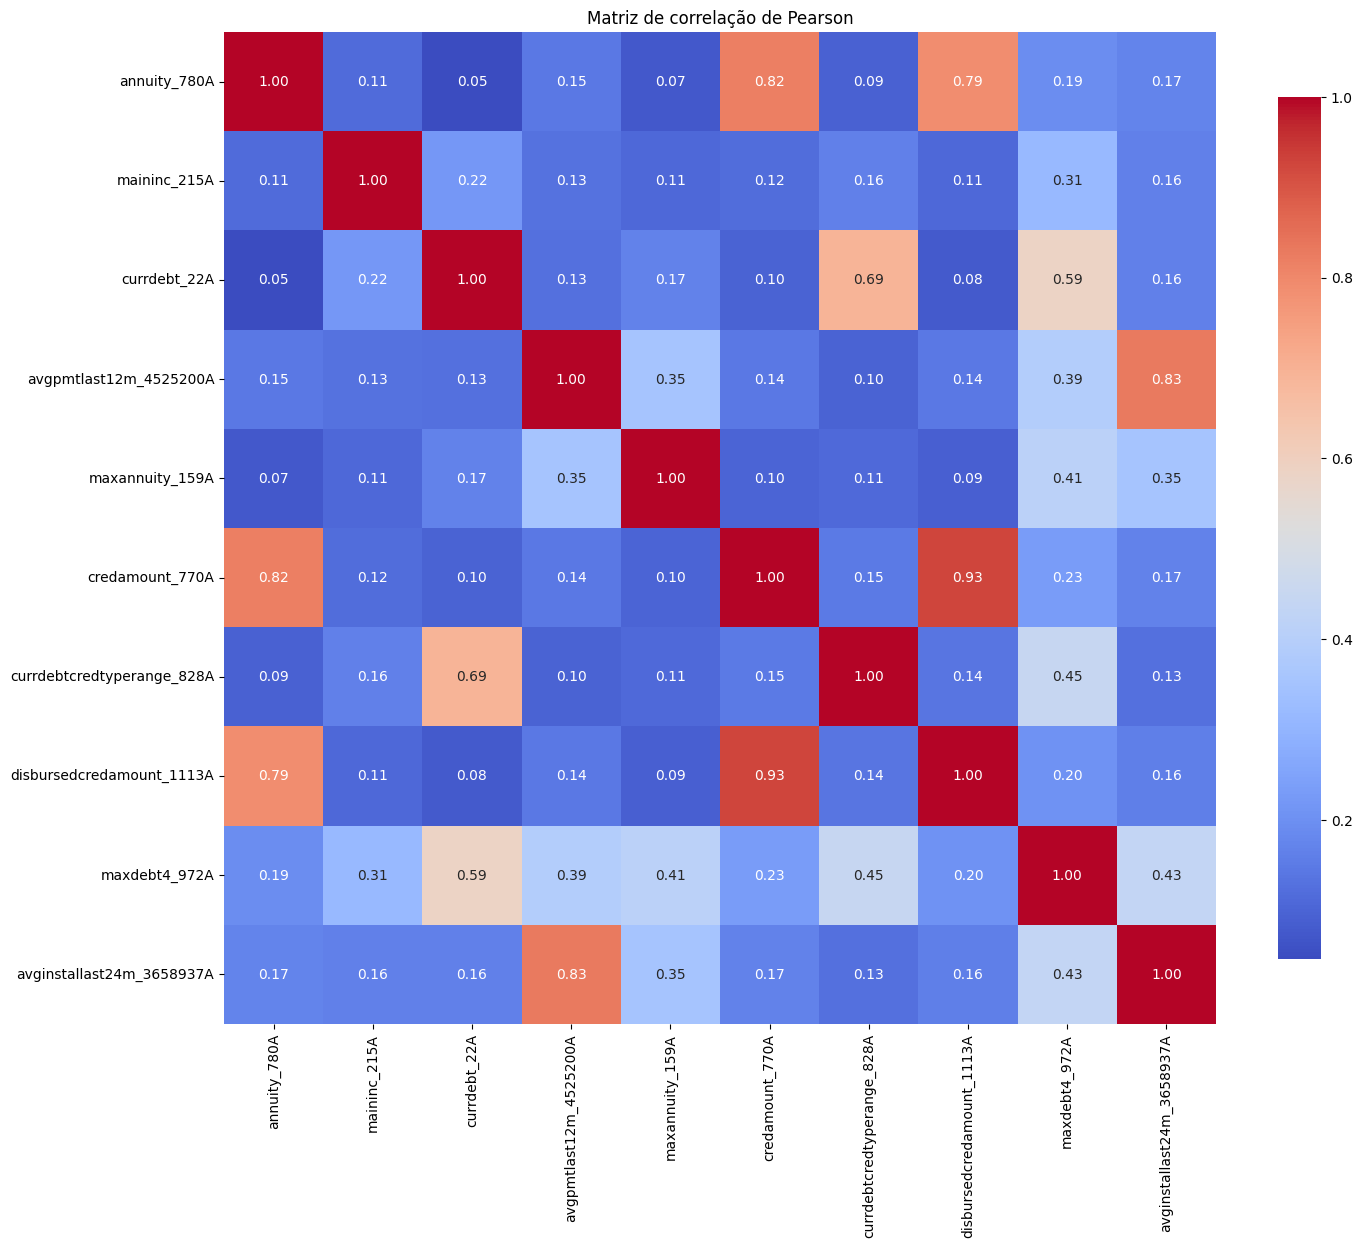

In [20]:
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de correlação de Pearson')
plt.show()

## Tratamento de Multicolinearidade

Durante a análise de correlação, identifiquei pares de variáveis com correlação de Pearson acima de 0.8. Abaixo, justifico a decisão de exclusão para cada par, considerando tanto a teoria de risco de crédito quanto a robustez e interpretabilidade em modelos de machine learning.

### 1. `credamount_770A` x `disbursedcredamount_1113A`  
**Correlação:** 0.93

- **Descrição:**  
  - `credamount_770A`: Valor do crédito contratado.
  - `disbursedcredamount_1113A`: Valor efetivamente desembolsado do crédito.
- **Decisão:**  
  - **Manter:** `disbursedcredamount_1113A`
  - **Excluir:** `credamount_770A`
- **Justificativa:**  
  O valor desembolsado (`disbursedcredamount_1113A`) representa o montante realmente recebido pelo cliente, sendo mais fiel à exposição real ao risco de crédito. O valor contratado pode incluir taxas ou valores não liberados, tornando-se menos representativo para o risco efetivo.

### 2. `avgpmtlast12m_4525200A` x `avginstallast24m_3658937A`  
**Correlação:** 0.83

- **Descrição:**  
  - `avgpmtlast12m_4525200A`: Média dos pagamentos realizados nos últimos 12 meses.
  - `avginstallast24m_3658937A`: Média das parcelas pagas nos últimos 24 meses.
- **Decisão:**  
  - **Manter:** `avgpmtlast12m_4525200A`
  - **Excluir:** `avginstallast24m_3658937A`
- **Justificativa:**  
  A média dos pagamentos nos últimos 12 meses (`avgpmtlast12m_4525200A`) reflete o comportamento mais recente do cliente, sendo mais relevante para modelos preditivos de inadimplência, que tendem a valorizar padrões atuais.

### 3. `annuity_780A` x `credamount_770A`  
**Correlação:** 0.82

- **Descrição:**  
  - `annuity_780A`: Valor da anuidade mensal do contrato.
  - `credamount_770A`: Valor do crédito contratado.
- **Decisão:**  
  - **Manter:** `annuity_780A`
  - **Excluir:** `credamount_770A`
- **Justificativa:**  
  O valor da anuidade mensal (`annuity_780A`) está diretamente relacionado ao compromisso financeiro mensal do cliente, sendo mais útil para avaliar a capacidade de pagamento e o risco de inadimplência. O valor total do crédito, além de já estar representado por outras variáveis, é menos sensível ao fluxo de caixa mensal do cliente.

> **Resumo:**  
> Para cada par altamente correlacionado, mantive a variável que melhor representa o risco de crédito do ponto de vista prático e teórico, além de ser mais útil para modelos de machine learning. Essa abordagem reduz redundância, melhora a interpretabilidade e contribui para a robustez do modelo.

In [21]:
to_drop = ['credamount_770A', 'avginstallast24m_3658937A']

df_train_model = df_train_model.drop(to_drop)

In [22]:
df_train_model.shape

(300000, 44)

### 1.4.2 - Verificando valores nulos

In [23]:
percentual_nulos = (df_train_model.select([(pl.col(col).is_null().sum() / df_train_model.height).alias(col)
        for col in df_train_model.columns
    ])
    .to_dict(as_series=False)
)

print(f"Total de colunas: {len(df_train_model.columns)}")

print("")

for limite_percentual in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35]:
    col_acima_limite = [col for col, pct in percentual_nulos.items() if pct[0] > limite_percentual]
    print(f"Threshold > {int(limite_percentual*100)}%: Total: {len(col_acima_limite)} - Cols: {col_acima_limite}")

Total de colunas: 44

Threshold > 5%: Total: 23 - Cols: ['maxdpdlast24m_143P', 'maxdpdlast12m_727P', 'maxdpdlast6m_474P', 'maxdpdlast3m_392P', 'pctinstlsallpaidlate1d_3546856L', 'pctinstlsallpaidlate4d_3546849L', 'avgdbddpdlast24m_3658932P', 'datelastunpaid_3546854D', 'maininc_215A', 'avgpmtlast12m_4525200A', 'maxannuity_159A', 'maxdebt4_972A', 'lastapprdate_640D', 'lastrepayingdate_696D', 'numinstpaidlate1d_3546852L', 'numinstlsallpaid_934L', 'numinstlswithoutdpd_562L', 'pctinstlsallpaidearl3d_427L', 'equalitydataagreement_891L', 'days30_165L', 'days90_310L', 'riskassesment_302T', 'riskassesment_940T']
Threshold > 10%: Total: 21 - Cols: ['maxdpdlast24m_143P', 'maxdpdlast12m_727P', 'maxdpdlast6m_474P', 'maxdpdlast3m_392P', 'pctinstlsallpaidlate1d_3546856L', 'pctinstlsallpaidlate4d_3546849L', 'avgdbddpdlast24m_3658932P', 'datelastunpaid_3546854D', 'maininc_215A', 'avgpmtlast12m_4525200A', 'maxannuity_159A', 'maxdebt4_972A', 'lastapprdate_640D', 'lastrepayingdate_696D', 'numinstpaidlate1

In [24]:
limite_nulos = 0.30
colunas_nulas = [col for col, pct in percentual_nulos.items() if pct[0] > limite_nulos]

colunas_para_excluir = ['datelastunpaid_3546854D', 'lastrepayingdate_696D']  
colunas_flag = ['equalitydataagreement_891L']
colunas_score = ['riskassesment_302T', 'riskassesment_940T'] 

colunas_numericas = [
    'pctinstlsallpaidlate1d_3546856L',
    'pctinstlsallpaidlate4d_3546849L',
    'avgdbddpdlast24m_3658932P',
    'maininc_215A',
    'avgpmtlast12m_4525200A',
    'pctinstlsallpaidearl3d_427L'
]

df_train_model = df_train_model.drop(colunas_para_excluir)



In [25]:
for col in colunas_flag:
    if col in df_train_model.columns:
        df_train_model = df_train_model.with_columns(
            pl.col(col).cast(pl.Int64).fill_null(0)
        )


### 1.4.3 - Retirando outras colunas

In [26]:
df_train_model = df_train_model.drop(['date_decision', 'MONTH', 'WEEK_NUM'])

In [27]:
# cols_para_remover = [col for col in df_train_model.columns if col.endswith('M') and col not in ['lastrejectreasonclient_4145040M', 'maritalst_893M', 'maritalst_385M', 'description_5085714M', 'education_88M']]
# df_train_model = df_train_model.drop(cols_para_remover)

In [28]:
df_train_model.head()

case_id,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,annuity_780A,maininc_215A,currdebt_22A,avgpmtlast12m_4525200A,maxannuity_159A,currdebtcredtyperange_828A,disbursedcredamount_1113A,maxdebt4_972A,numactivecreds_622L,numcontrs3months_479L,lastapprdate_640D,applications30d_658L,numrejects9m_859L,applicationscnt_1086L,lastcancelreason_561M,lastrejectreason_759M,numinstpaidlate1d_3546852L,numinstlsallpaid_934L,numinstlswithoutdpd_562L,pctinstlsallpaidearl3d_427L,mobilephncnt_593L,homephncnt_628L,clientscnt12m_3712952L,equalitydataagreement_891L,days30_165L,days90_310L,riskassesment_302T,riskassesment_940T,education_1103M,maritalst_385M
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,str,f64,str,str
"""927416""",0,0.0,0.0,0.0,0.0,null,null,null,2394.8,null,0.0,null,0.0,0.0,11596.0,0.0,0.0,1.0,null,0.0,1.0,0.0,"""P94_109_143""","""P45_84_106""",null,null,null,null,2.0,1.0,0.0,0,0.0,3.0,null,null,"""a55475b1""","""a55475b1"""
"""1654713""",0,5.0,5.0,0.0,0.0,0.66667,0.16667,1.0,3666.6,30000.0,0.0,2329.0,4700.0,0.0,43998.0,22708.0,0.0,0.0,"""2018-06-08""",0.0,0.0,0.0,"""a55475b1""","""a55475b1""",8.0,4.0,5.0,0.08333,1.0,0.0,0.0,0,0.0,0.0,null,null,"""a55475b1""","""a55475b1"""
"""1324157""",0,3.0,3.0,0.0,0.0,0.1875,0.12766,-40.0,1333.6,34000.0,29380.4,null,14527.601,0.0,15996.0,49322.57,2.0,0.0,"""2018-11-15""",0.0,0.0,0.0,"""a55475b1""","""a55475b1""",9.0,39.0,41.0,0.66667,3.0,1.0,0.0,0,0.0,0.0,null,null,"""6b2ae0fa""","""3439d993"""
"""2530188""",0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,5600.6,69600.0,0.0,null,19099.154,0.0,90000.0,45415.574,2.0,1.0,"""2018-11-04""",0.0,4.0,0.0,"""a55475b1""","""P94_109_143""",0.0,15.0,37.0,1.0,2.0,1.0,0.0,0,null,null,null,null,null,null
"""1868496""",0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,2782.0,160000.0,121302.0,6387.8003,6420.0,0.0,39240.0,100000.0,1.0,0.0,"""2020-01-29""",0.0,0.0,0.0,"""a55475b1""","""a55475b1""",0.0,5.0,5.0,1.0,1.0,0.0,0.0,0,1.0,1.0,null,null,"""a55475b1""","""a55475b1"""


---

## 1.5 - Transformação das variáveis

### 1.5.1 - Histograma

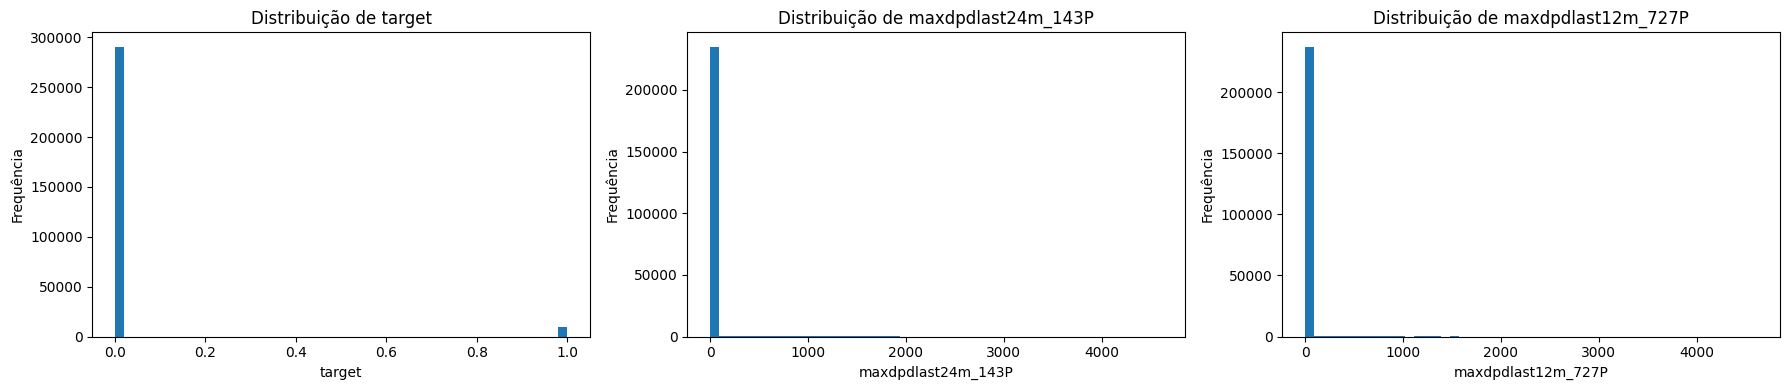

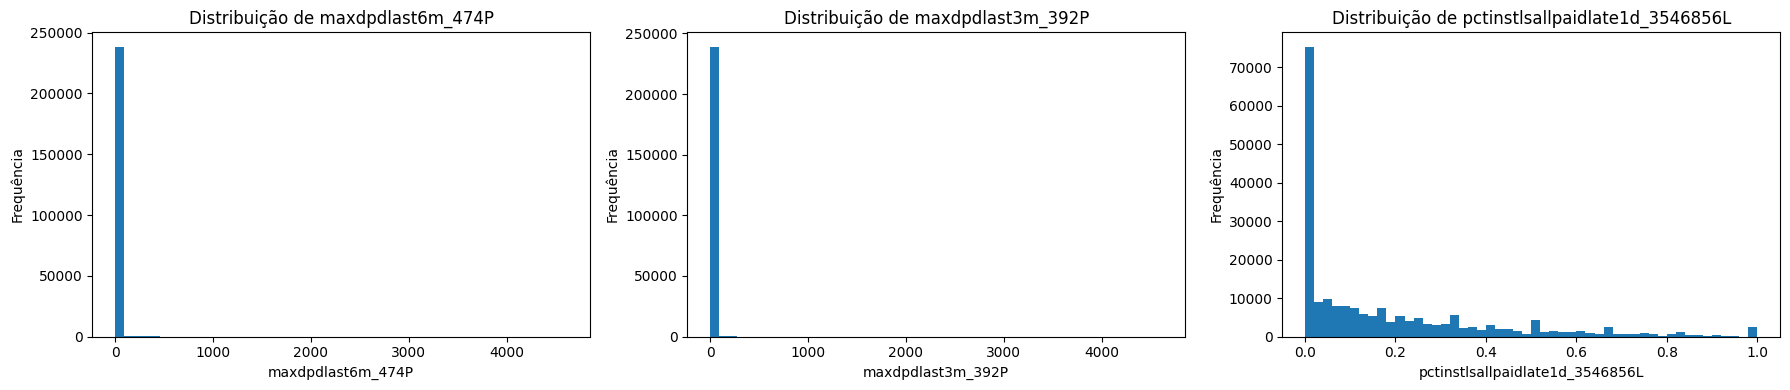

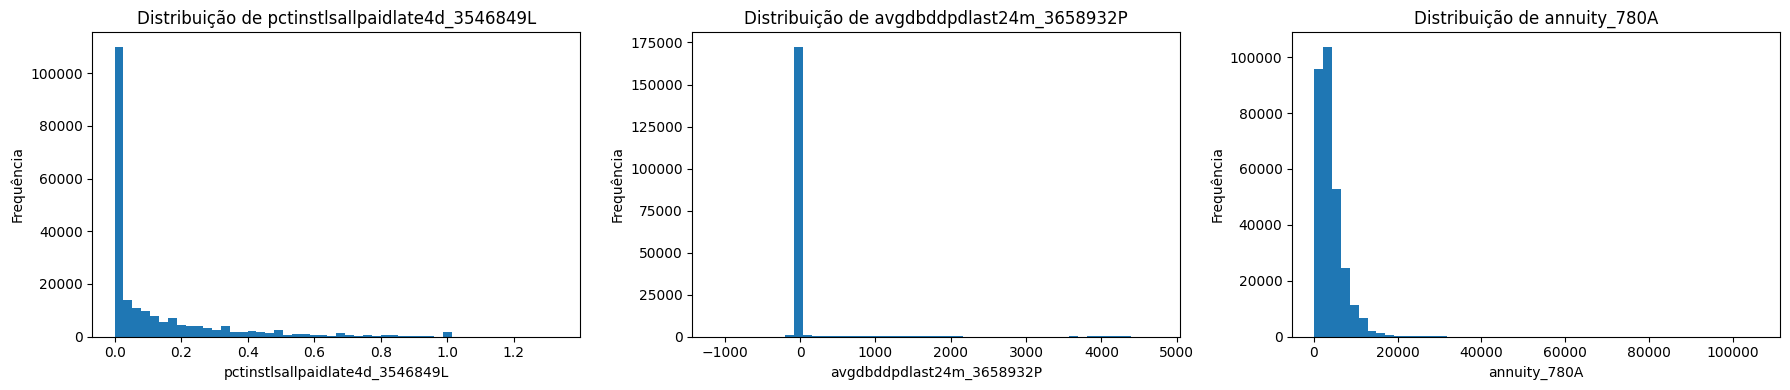

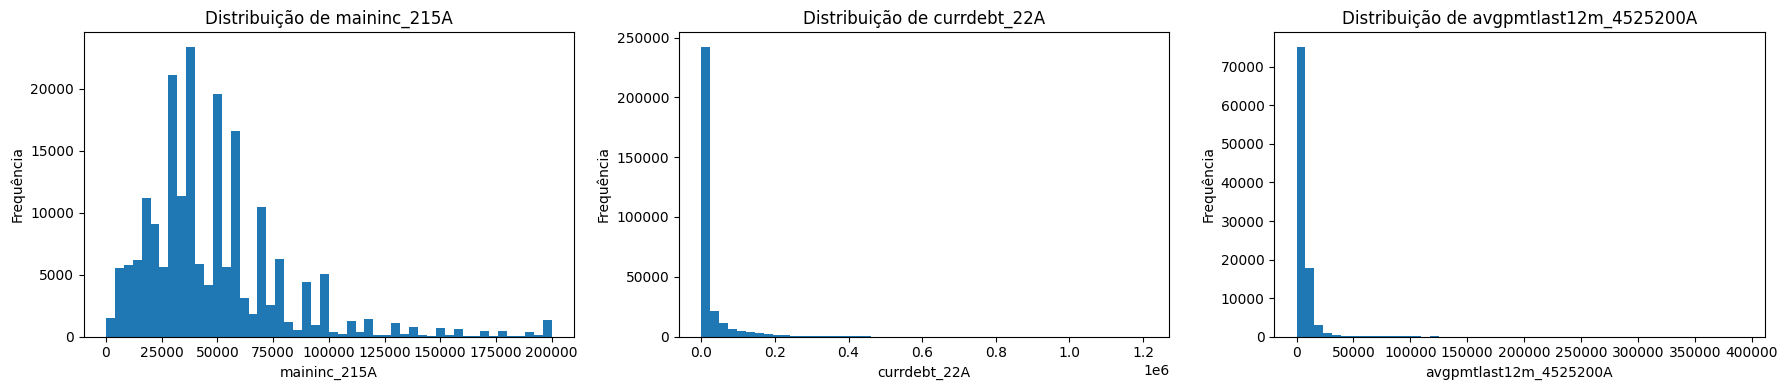

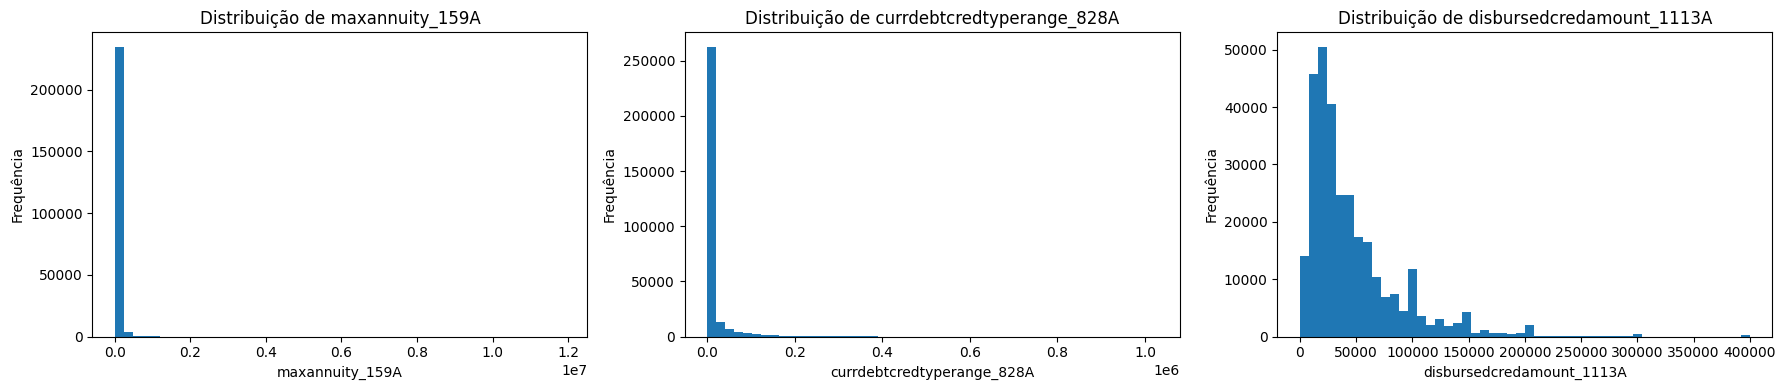

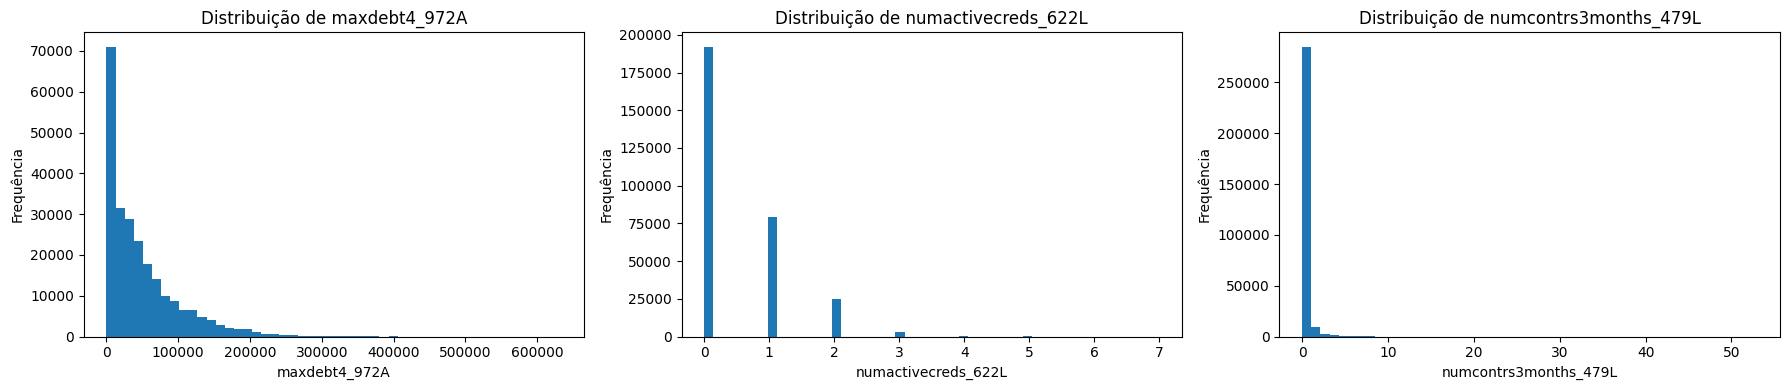

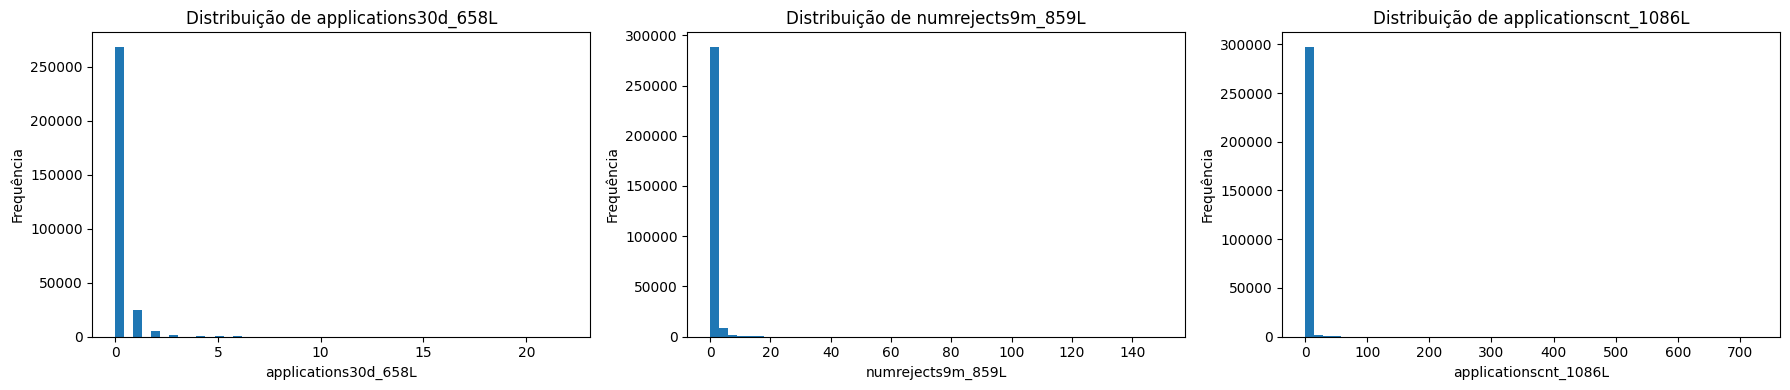

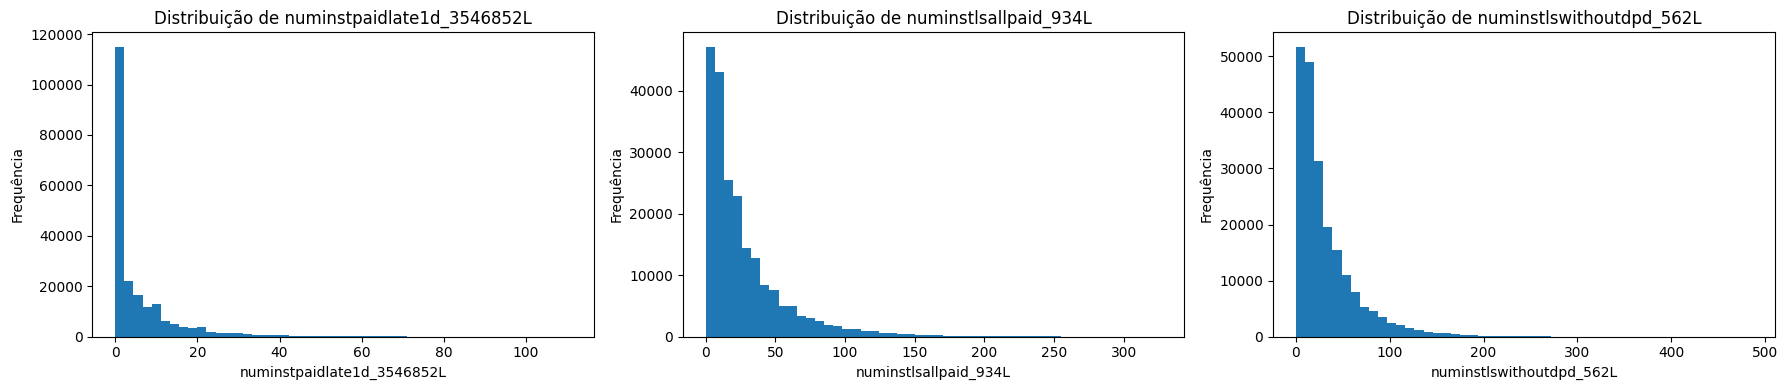

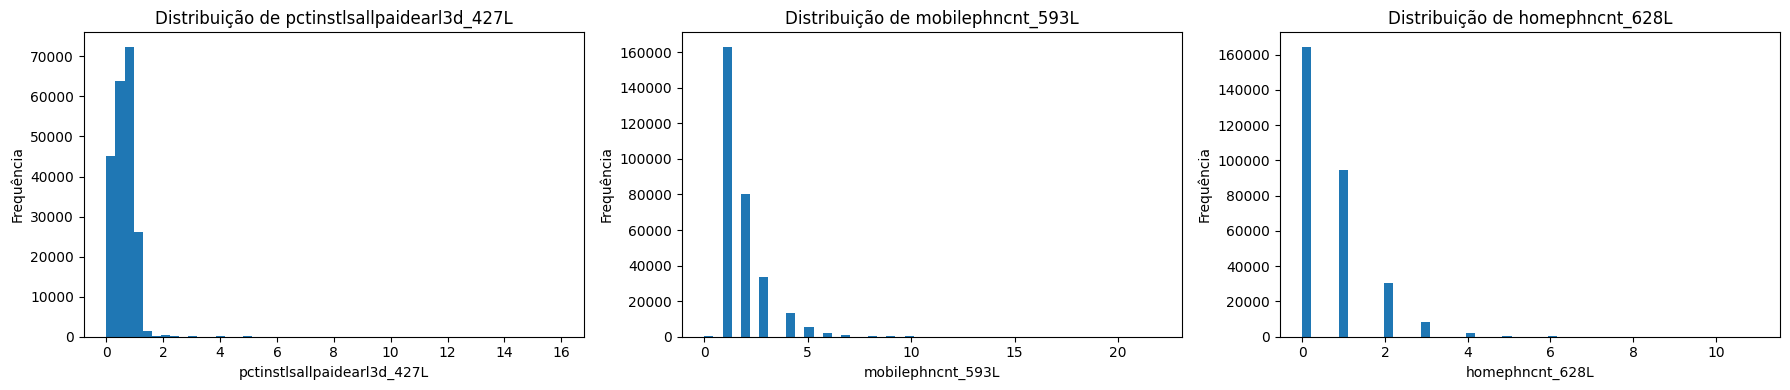

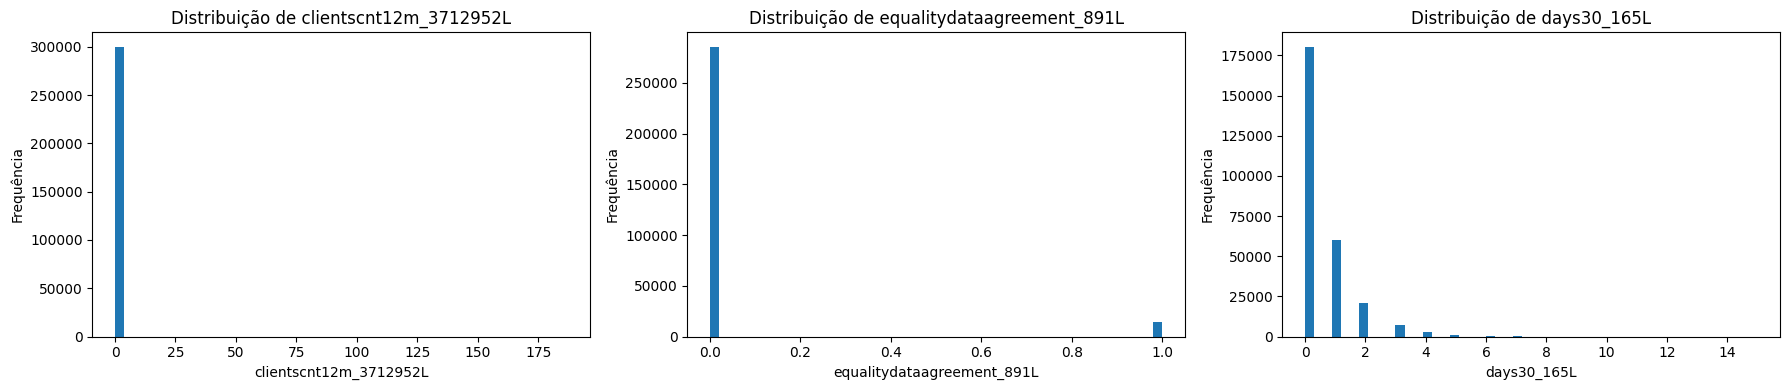

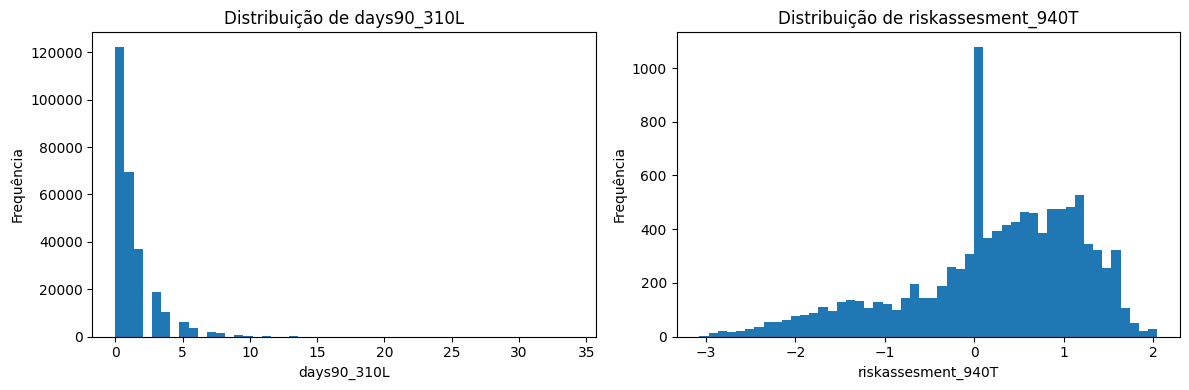

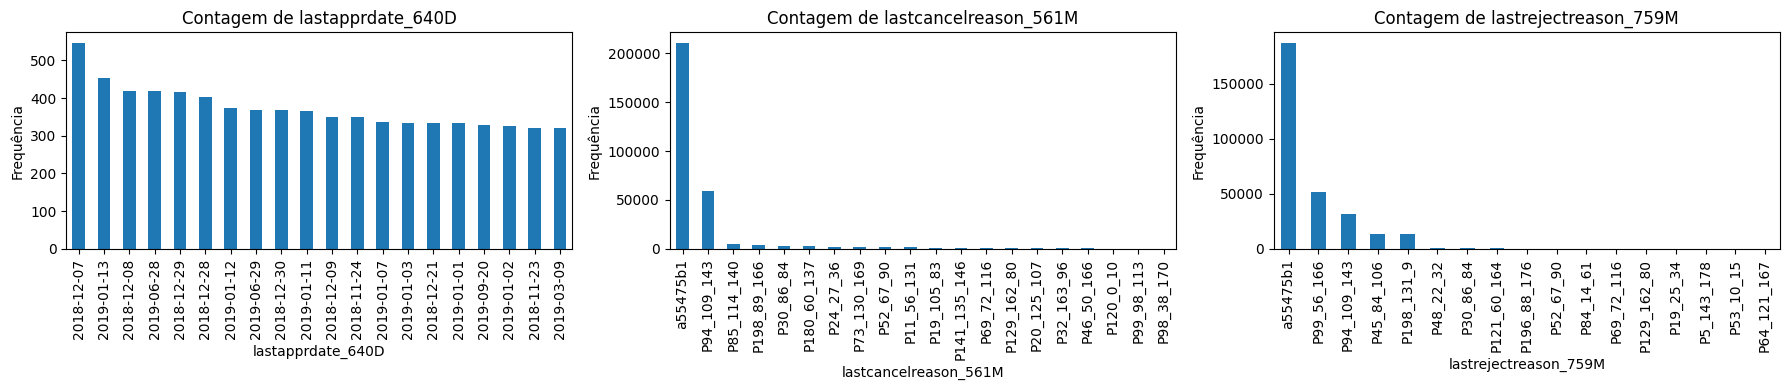

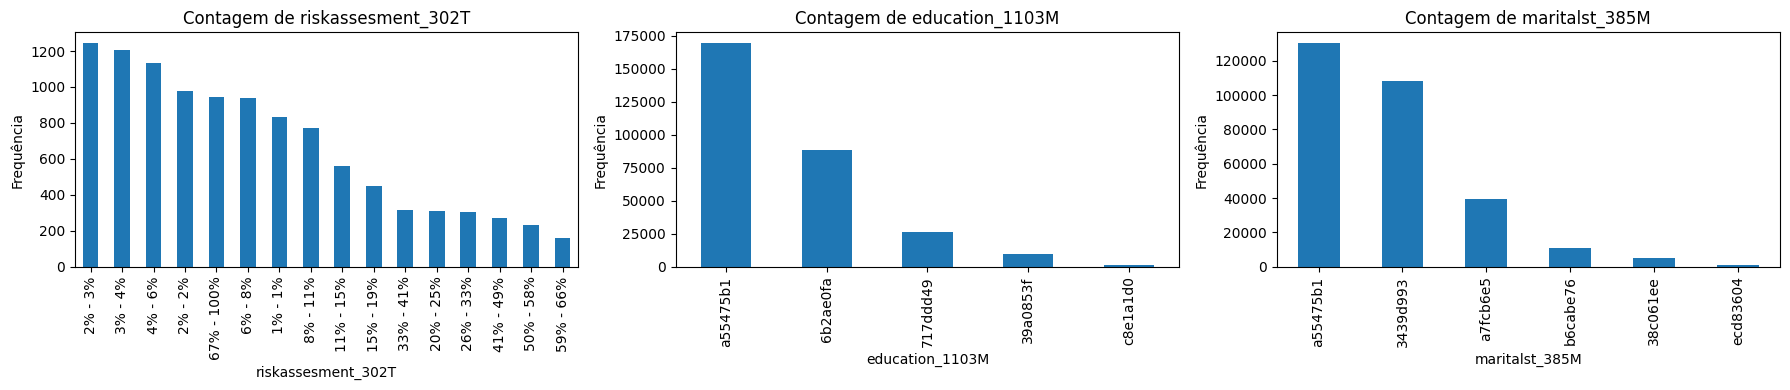

In [29]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

def plotar_distribuicao_colunas(df, colunas):
    for i in range(0, len(colunas), 3):
        subset = colunas[i:i+3]
        fig, axs = plt.subplots(1, len(subset), figsize=(6 * len(subset), 4))
        if len(subset) == 1:
            axs = [axs]
        for ax, coluna in zip(axs, subset):
            serie = df[coluna].to_pandas()
            if pd.api.types.is_numeric_dtype(serie):
                serie.hist(bins=50, ax=ax)
                ax.set_title(f'Distribuição de {coluna}')
                ax.set_xlabel(coluna)
                ax.set_ylabel('Frequência')
            else:
                # Para categóricas, limita a 20 categorias para visualização
                value_counts = serie.value_counts().sort_values(ascending=False)[:20]
                value_counts.plot(kind='bar', ax=ax)
                ax.set_title(f'Contagem de {coluna}')
                ax.set_xlabel(coluna)
                ax.set_ylabel('Frequência')
            ax.grid(False)
        plt.tight_layout()
        plt.show()

# Lista de tipos numéricos em Polars
tipos_numericos = [
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64
]

# Identifica colunas numéricas e categóricas
colunas_numericas = [col for col in df_train_model.columns if df_train_model[col].dtype in tipos_numericos]
colunas_categoricas = [col for col in df_train_model.columns if df_train_model[col].dtype not in tipos_numericos and col not in ['case_id', 'target']]

# Plota histogramas para numéricas
plotar_distribuicao_colunas(df_train_model, colunas_numericas)

# Plota gráficos de barras para categóricas (se houver)
if colunas_categoricas:
    plotar_distribuicao_colunas(df_train_model, colunas_categoricas)

### 1.5.2 - BoxPlot

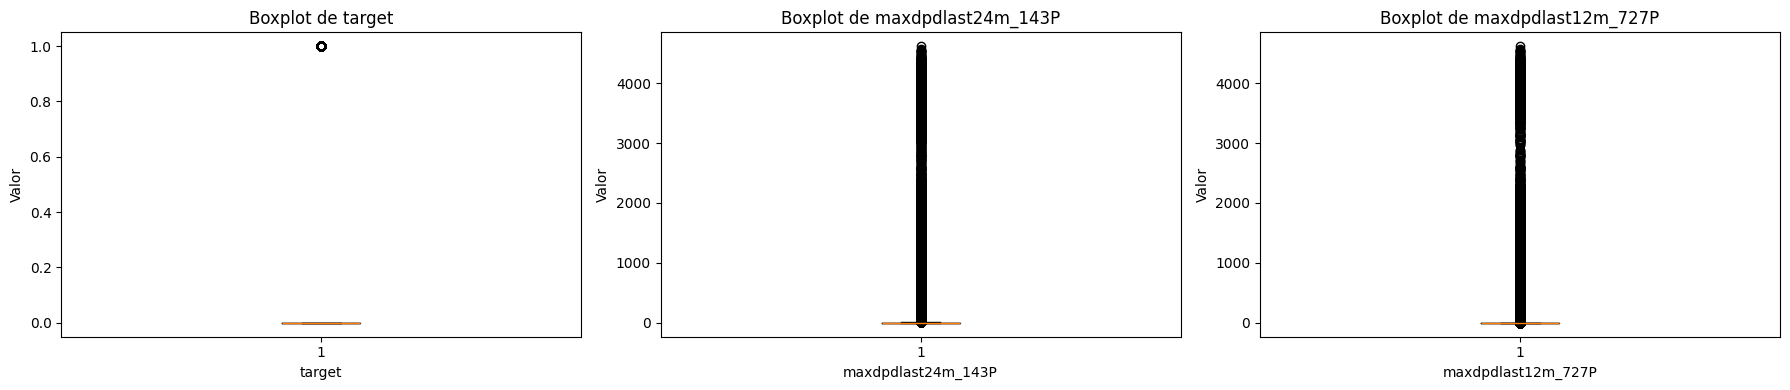

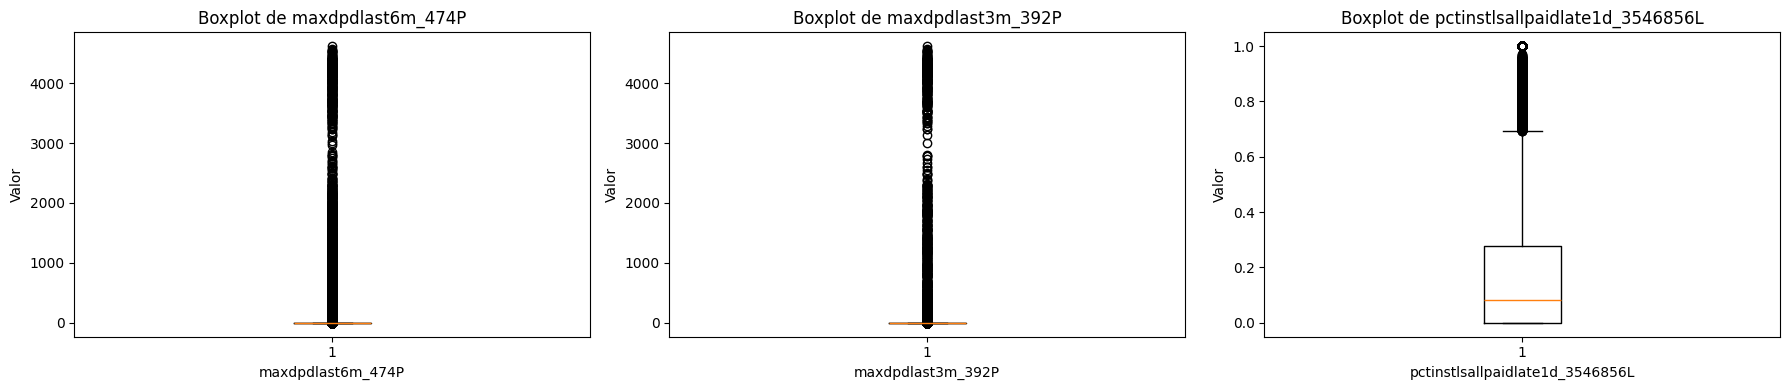

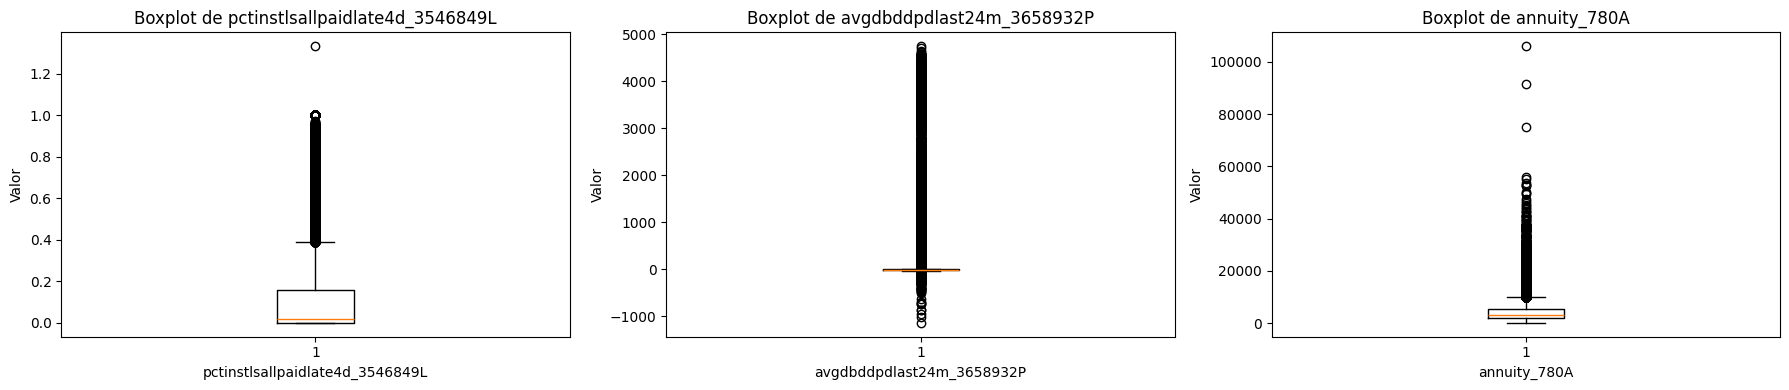

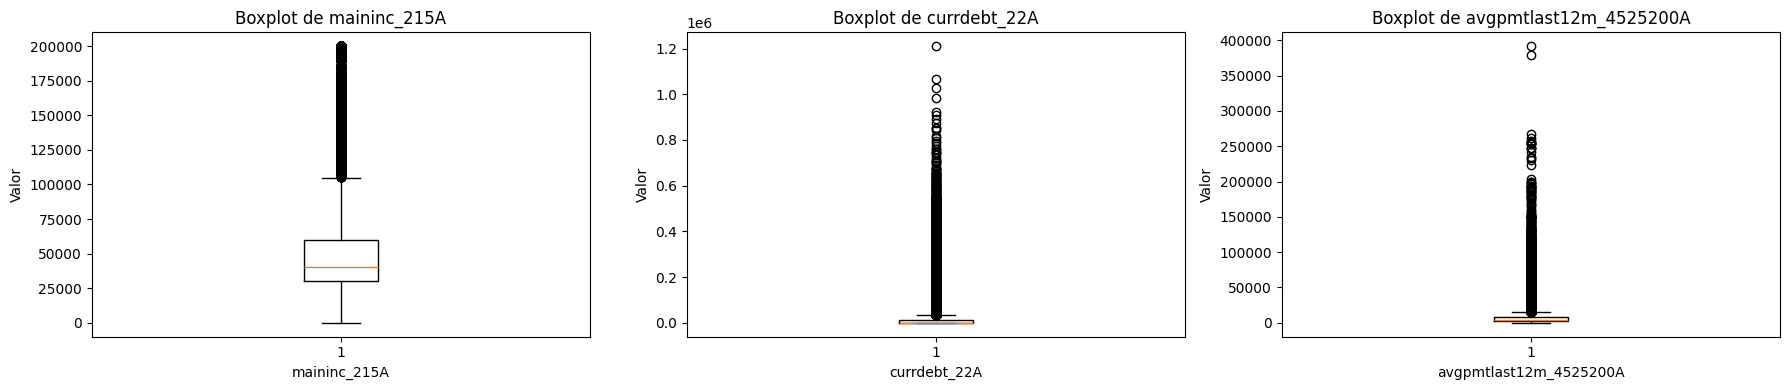

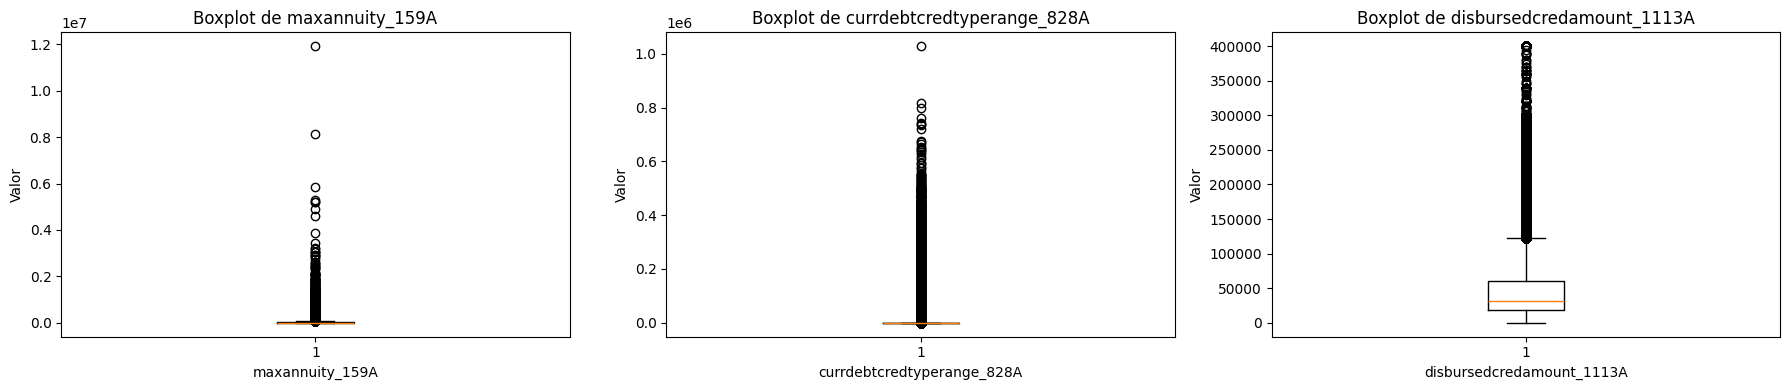

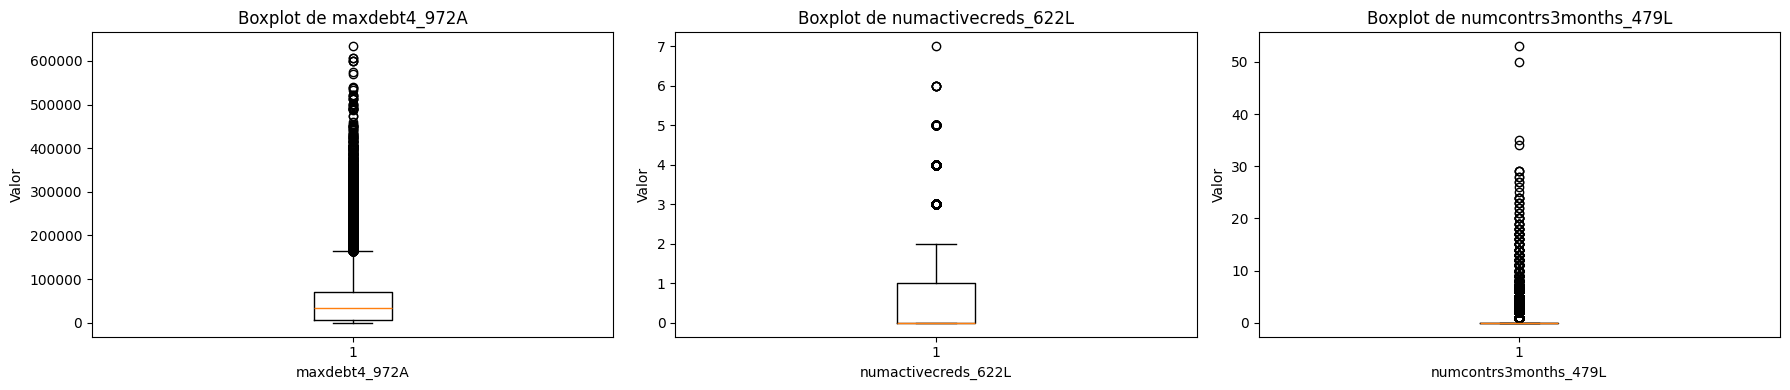

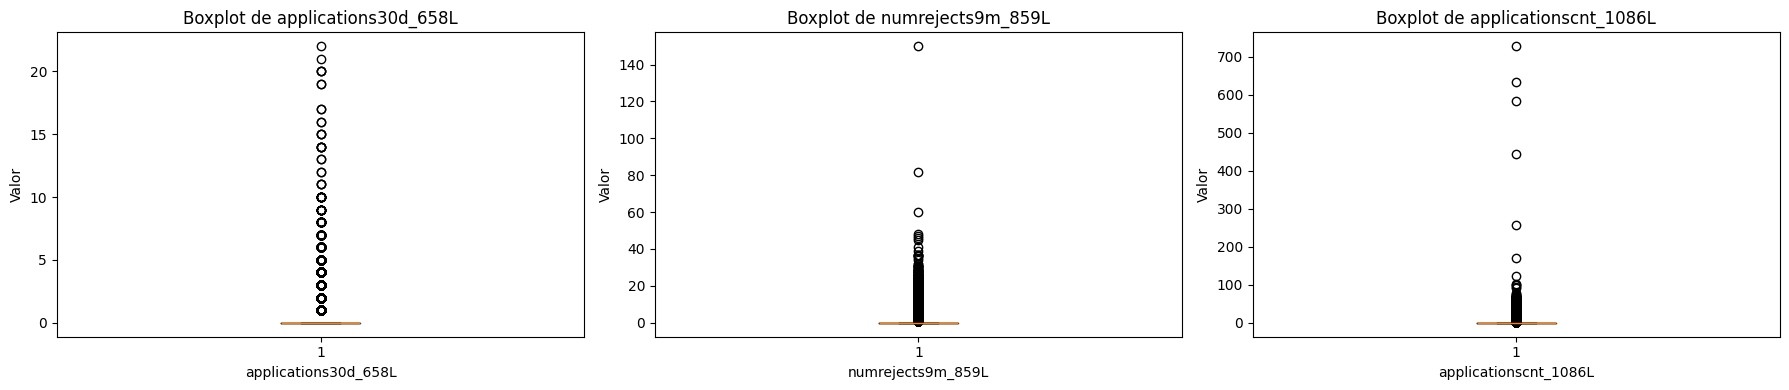

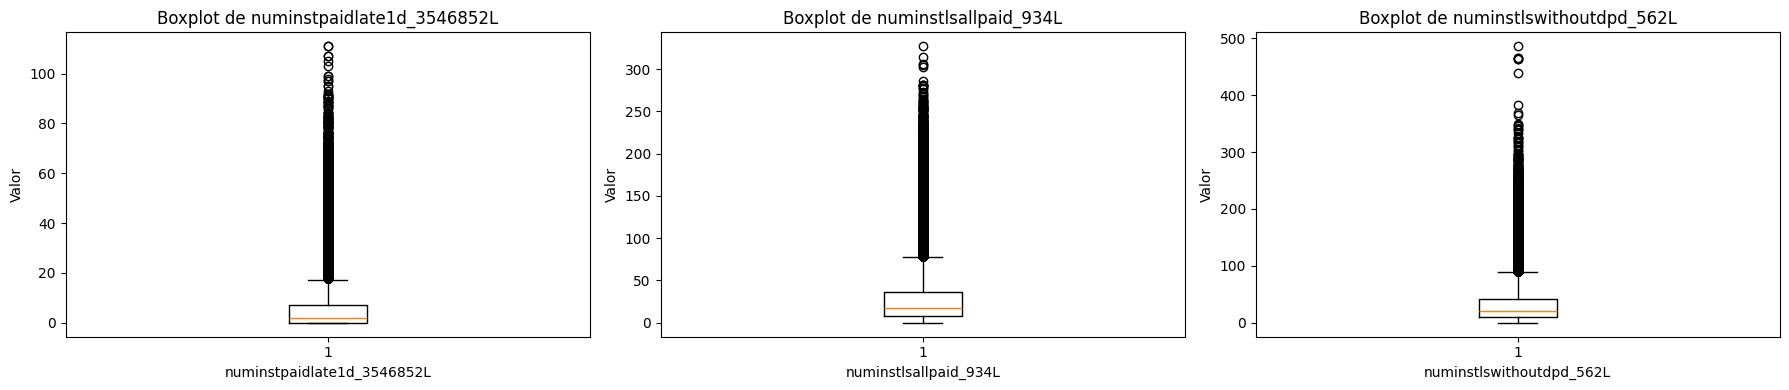

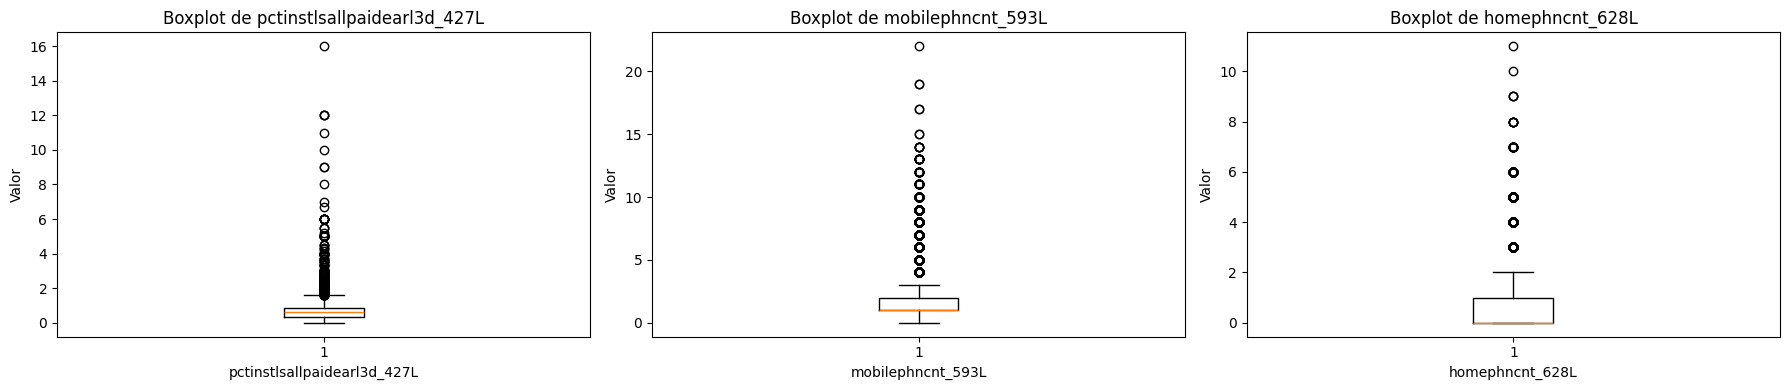

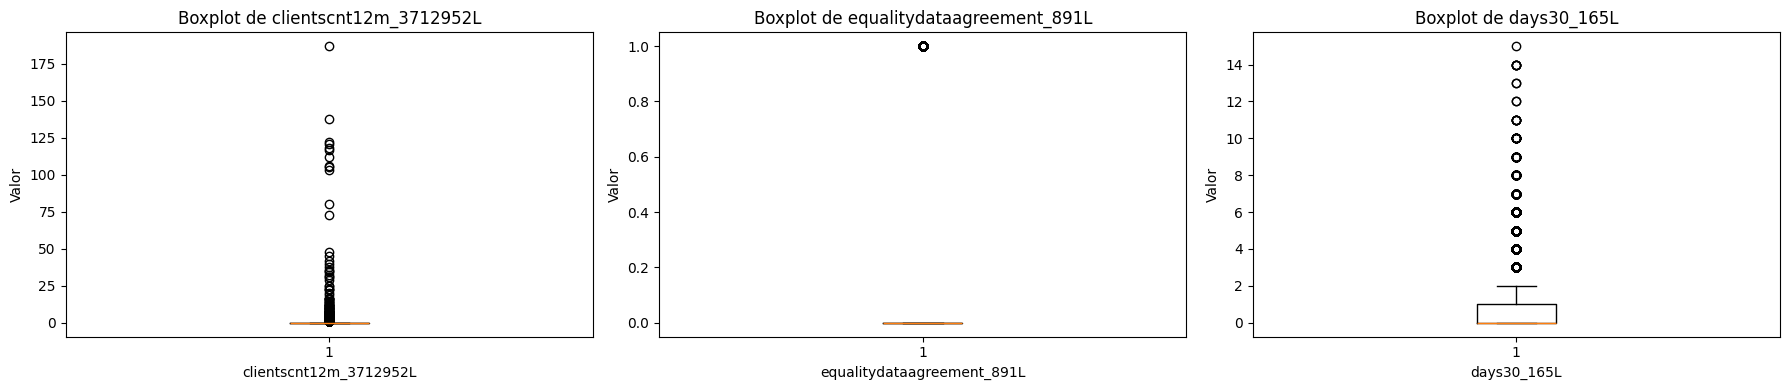

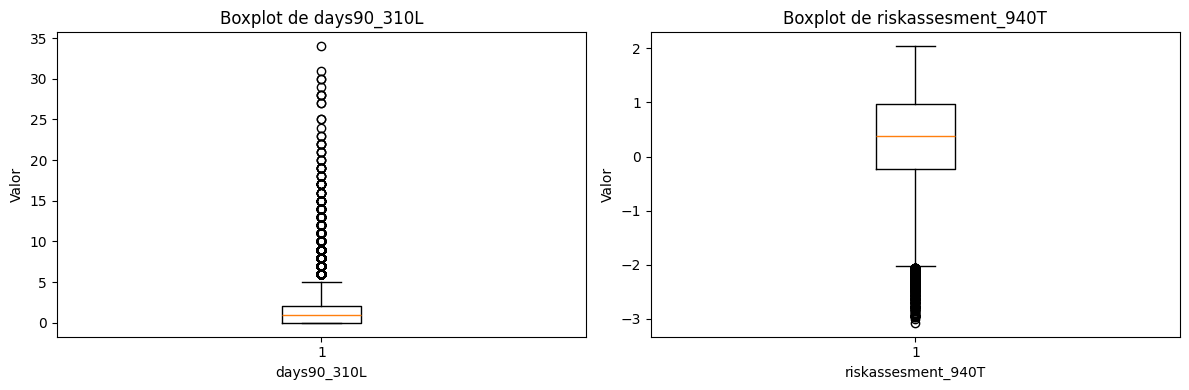

In [30]:
import matplotlib.pyplot as plt
import polars as pl

# Lista de tipos numéricos em Polars
tipos_numericos = [
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64
]

def plotar_boxplot_colunas(df, colunas):
    for i in range(0, len(colunas), 3):
        subset = colunas[i:i+3]
        fig, axs = plt.subplots(1, len(subset), figsize=(6 * len(subset), 4))
        if len(subset) == 1:
            axs = [axs]
        for ax, coluna in zip(axs, subset):
            serie = df[coluna].to_pandas().dropna()
            ax.boxplot(serie, vert=True)
            ax.set_title(f'Boxplot de {coluna}')
            ax.set_xlabel(coluna)
            ax.set_ylabel('Valor')
            ax.grid(False)
        plt.tight_layout()
        plt.show()

# Identifica todas as colunas numéricas
colunas_numericas = [col for col in df_train_model.columns if df_train_model[col].dtype in tipos_numericos]

# Plota boxplots para todas as numéricas
plotar_boxplot_colunas(df_train_model, colunas_numericas)

---

## 1.6 - Transformando as variáveis categóricas [M]

> Feature Númerica da coluna D


In [31]:
df_train_model['lastapprdate_640D']

lastapprdate_640D
str
null
"""2018-06-08"""
"""2018-11-15"""
"""2018-11-04"""
"""2020-01-29"""
…
"""2018-03-29"""
"""2017-01-10"""
"""2017-08-04"""


In [32]:
def extract_date_features(df, date_col='lastapprdate_640D'):
    df = df.with_columns(
        pl.col(date_col).str.strptime(pl.Date, format="%Y-%m-%d", strict=False).alias(date_col)
    )
    
    max_date = df.select(pl.col(date_col).max()).item()
    
    df = df.with_columns([
        pl.col(date_col).dt.year().alias(f"{date_col}_year"),
        pl.col(date_col).dt.month().alias(f"{date_col}_month"),
        pl.col(date_col).dt.day().alias(f"{date_col}_day"),
        pl.col(date_col).dt.weekday().alias(f"{date_col}_weekday"),
        pl.col(date_col).dt.quarter().alias(f"{date_col}_quarter"),
        (pl.col(date_col) - pl.date(2024, 1, 1)).dt.total_days().alias(f"{date_col}_days_since_ref"),
        (pl.lit(max_date) - pl.col(date_col)).dt.total_days().alias(f"{date_col}_days_ago")
    ])
    
    return df

df_train_model = extract_date_features(df_train_model, 'lastapprdate_640D')

In [33]:
date_features = [col for col in df_train_model.columns if 'lastapprdate_640D' in col and col != 'lastapprdate_640D']

for col in date_features:
    moda_series = df_train_model.select(pl.col(col).drop_nulls()).to_series().mode()
    if len(moda_series) > 0:
        moda_value = moda_series[0]
    else:
        moda_value = -1
    df_train_model = df_train_model.with_columns(
        pl.col(col).fill_null(moda_value).alias(col)
    )

In [34]:
df_train_model = df_train_model.drop('lastapprdate_640D')

In [35]:
df_train_model.tail()

case_id,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,annuity_780A,maininc_215A,currdebt_22A,avgpmtlast12m_4525200A,maxannuity_159A,currdebtcredtyperange_828A,disbursedcredamount_1113A,maxdebt4_972A,numactivecreds_622L,numcontrs3months_479L,applications30d_658L,numrejects9m_859L,applicationscnt_1086L,lastcancelreason_561M,lastrejectreason_759M,numinstpaidlate1d_3546852L,numinstlsallpaid_934L,numinstlswithoutdpd_562L,pctinstlsallpaidearl3d_427L,mobilephncnt_593L,homephncnt_628L,clientscnt12m_3712952L,equalitydataagreement_891L,days30_165L,days90_310L,riskassesment_302T,riskassesment_940T,education_1103M,maritalst_385M,lastapprdate_640D_year,lastapprdate_640D_month,lastapprdate_640D_day,lastapprdate_640D_weekday,lastapprdate_640D_quarter,lastapprdate_640D_days_since_ref,lastapprdate_640D_days_ago
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,str,f64,str,str,i32,i8,i8,i8,i8,i64,i64
"""1415729""",0,0.0,0.0,0.0,0.0,0.0,0.0,-17.0,2056.4001,75400.0,199968.0,null,35760.0,0.0,19570.0,180003.47,1.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",0.0,36.0,37.0,0.88889,2.0,1.0,1.0,0,1.0,1.0,null,null,"""6b2ae0fa""","""3439d993""",2018,3,29,4,1,-2104,935
"""149718""",0,0.0,0.0,0.0,0.0,0.87179,0.87179,null,3787.4001,40000.0,0.0,null,8055.8003,0.0,20000.0,42800.0,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""P99_56_166""",34.0,6.0,8.0,0.07692,3.0,2.0,0.0,0,0.0,1.0,null,null,"""6b2ae0fa""","""3439d993""",2017,1,10,2,1,-2547,1378
"""1508249""",0,1.0,0.0,0.0,0.0,0.16667,0.0,-5.0,1379.8,40000.0,0.0,null,8040.0,0.0,22998.0,24636.0,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",1.0,5.0,12.0,0.33333,1.0,0.0,0.0,0,0.0,0.0,"""2% - 3%""",0.893415,"""6b2ae0fa""","""38c061ee""",2017,8,4,5,3,-2341,1172
"""1446900""",0,0.0,0.0,0.0,0.0,0.03704,0.03704,-14.0,1224.0,170000.0,0.0,null,5997.6,0.0,10978.0,55998.0,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",1.0,26.0,27.0,0.96296,1.0,1.0,0.0,0,0.0,0.0,null,null,"""6b2ae0fa""","""a7fcb6e5""",2017,10,10,2,4,-2274,1105
"""4752""",0,null,null,null,null,null,null,null,7776.2,null,0.0,null,null,0.0,101000.0,null,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""",null,null,null,null,1.0,0.0,0.0,0,0.0,0.0,null,null,"""a55475b1""","""3439d993""",2019,12,27,5,4,-1851,682


> #### Resolvendo os valores nulos / ausentes das colunas com final 'M'
**Antes**

In [36]:
(df_train_model.select([col for col in df_train_model.columns if col.endswith('')]).null_count() / df_train_model.height * 100)

case_id,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,annuity_780A,maininc_215A,currdebt_22A,avgpmtlast12m_4525200A,maxannuity_159A,currdebtcredtyperange_828A,disbursedcredamount_1113A,maxdebt4_972A,numactivecreds_622L,numcontrs3months_479L,applications30d_658L,numrejects9m_859L,applicationscnt_1086L,lastcancelreason_561M,lastrejectreason_759M,numinstpaidlate1d_3546852L,numinstlsallpaid_934L,numinstlswithoutdpd_562L,pctinstlsallpaidearl3d_427L,mobilephncnt_593L,homephncnt_628L,clientscnt12m_3712952L,equalitydataagreement_891L,days30_165L,days90_310L,riskassesment_302T,riskassesment_940T,education_1103M,maritalst_385M,lastapprdate_640D_year,lastapprdate_640D_month,lastapprdate_640D_day,lastapprdate_640D_weekday,lastapprdate_640D_quarter,lastapprdate_640D_days_since_ref,lastapprdate_640D_days_ago
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,20.052,20.052,20.052,20.052,30.099,30.163667,40.267667,0.0,33.56,0.0,67.313,20.052,0.0,0.0,20.052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.698333,29.249333,29.943667,30.099,0.0,0.0,0.0,0.0,9.236,9.236,96.451,96.451,1.695667,1.695667,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Função**

In [37]:
def preencher_proporcional(col):
    """ Preenche valores ausentes na mesma proporção dos valores presentes

    Recebe uma coluna e retorna a coluna com os valores ausentes preenchidos
    na proporção dos valores previamente existentes."""
    
    # Gerando o dicionário com valores únicos e sua porcentagens
    percentages = col.value_counts(normalize=True).to_dict()
    percent = [percentages[key] for key in percentages]
    labels = [key for key in percentages]
    s = pd.Series(np.random.choice(labels, p=percent, size=col.isnull().sum()))
    col = col.fillna(s)
    
    if len(col.isnull()) > 0:
        col.fillna(value=max(percentages, key=percentages.get), inplace=True, axis=0)
        
    return col

cols_m = [col for col in df_train_model.columns if col.endswith('M')]

for col in cols_m:

    s = df_train_model[col].to_pandas()
    if s.dtype == 'O' or s.dtype.name == 'category' or s.dtype == 'str':
        s = preencher_proporcional(s)
    else:
        s = s.fillna(s.median())

    df_train_model = df_train_model.with_columns(pl.Series(col, s))

**Depois**

In [38]:
(df_train_model.select([col for col in df_train_model.columns if col.endswith('M')]).null_count() / df_train_model.height * 100)

lastcancelreason_561M,lastrejectreason_759M,education_1103M,maritalst_385M
f64,f64,f64,f64
0.0,0.0,0.0,0.0


> ### 1.6.1 - Aplicação de Label Encoding para as variaveis categoricas que apresentam ordem

In [39]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['lastcancelreason_561M', 'lastrejectreason_759M', 'riskassesment_302T']

for col in label_cols:
    label_encoder = LabelEncoder()
    col_data = df_train_model[col].to_pandas().fillna('Unknown').astype(str)
    encoded = label_encoder.fit_transform(col_data)
    df_train_model = df_train_model.with_columns(pl.Series(col, encoded))

> ### 1.6.2 - Aplicações de One Hot Enconder para as variaveis categoricas que não apresentam ordem

In [40]:
from sklearn.preprocessing import OneHotEncoder

coluna_one_hot = ['education_1103M', 'maritalst_385M']

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_one_hot = df_train_model.select(coluna_one_hot).to_pandas().fillna('Unknown').astype(str)
one_hot_encoded = one_hot_encoder.fit_transform(X_one_hot)
one_hot_feature_names = one_hot_encoder.get_feature_names_out(coluna_one_hot)
df_one_hot = pl.from_pandas(pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names))
df_train_model = df_train_model.drop(coluna_one_hot).hstack(df_one_hot)

In [41]:
df_train_model.shape

(300000, 54)

In [42]:
df_train_model.head()

case_id,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,annuity_780A,maininc_215A,currdebt_22A,avgpmtlast12m_4525200A,maxannuity_159A,currdebtcredtyperange_828A,disbursedcredamount_1113A,maxdebt4_972A,numactivecreds_622L,numcontrs3months_479L,applications30d_658L,numrejects9m_859L,applicationscnt_1086L,lastcancelreason_561M,lastrejectreason_759M,numinstpaidlate1d_3546852L,numinstlsallpaid_934L,numinstlswithoutdpd_562L,pctinstlsallpaidearl3d_427L,mobilephncnt_593L,homephncnt_628L,clientscnt12m_3712952L,equalitydataagreement_891L,days30_165L,days90_310L,riskassesment_302T,riskassesment_940T,lastapprdate_640D_year,lastapprdate_640D_month,lastapprdate_640D_day,lastapprdate_640D_weekday,lastapprdate_640D_quarter,lastapprdate_640D_days_since_ref,lastapprdate_640D_days_ago,education_1103M_39a0853f,education_1103M_6b2ae0fa,education_1103M_717ddd49,education_1103M_a55475b1,education_1103M_c8e1a1d0,maritalst_385M_3439d993,maritalst_385M_38c061ee,maritalst_385M_a55475b1,maritalst_385M_a7fcb6e5,maritalst_385M_b6cabe76,maritalst_385M_ecd83604
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,i32,i8,i8,i8,i8,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""927416""",0,0.0,0.0,0.0,0.0,null,null,null,2394.8,null,0.0,null,0.0,0.0,11596.0,0.0,0.0,1.0,0.0,1.0,0.0,54,6,null,null,null,null,2.0,1.0,0.0,0,0.0,3.0,16,null,2019,12,27,5,4,-1851,682,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""1654713""",0,5.0,5.0,0.0,0.0,0.66667,0.16667,1.0,3666.6,30000.0,0.0,2329.0,4700.0,0.0,43998.0,22708.0,0.0,0.0,0.0,0.0,0.0,60,16,8.0,4.0,5.0,0.08333,1.0,0.0,0.0,0,0.0,0.0,16,null,2018,6,8,5,2,-2033,864,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""1324157""",0,3.0,3.0,0.0,0.0,0.1875,0.12766,-40.0,1333.6,34000.0,29380.4,null,14527.601,0.0,15996.0,49322.57,2.0,0.0,0.0,0.0,0.0,60,16,9.0,39.0,41.0,0.66667,3.0,1.0,0.0,0,0.0,0.0,16,null,2018,11,15,4,4,-1873,704,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"""2530188""",0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,5600.6,69600.0,0.0,null,19099.154,0.0,90000.0,45415.574,2.0,1.0,0.0,4.0,0.0,60,14,0.0,15.0,37.0,1.0,2.0,1.0,0.0,0,null,null,16,null,2018,11,4,7,4,-1884,715,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"""1868496""",0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,2782.0,160000.0,121302.0,6387.8003,6420.0,0.0,39240.0,100000.0,1.0,0.0,0.0,0.0,0.0,60,16,0.0,5.0,5.0,1.0,1.0,0.0,0.0,0,1.0,1.0,16,null,2020,1,29,3,1,-1433,264,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 1.7 - Transformando as variáveis númericas [A]

> ### 1.7.1 - Normalização das colunas [A]
$$
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$


> Não necessário para o modelo utilizado

In [43]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# colunas_a = [col for col in df_train_model.columns if col.endswith('A')]
# df_train_model[colunas_a] = scaler.fit_transform(df_train_model[colunas_a].to_pandas())

----

## 1.8 - Retornando ao Pandas para aplicar o modelo

In [44]:
df_train_model = df_train_model.to_pandas()

In [45]:
df_train_model.describe()

,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,annuity_780A,maininc_215A,...,education_1103M_6b2ae0fa,education_1103M_717ddd49,education_1103M_a55475b1,education_1103M_c8e1a1d0,maritalst_385M_3439d993,maritalst_385M_38c061ee,maritalst_385M_a55475b1,maritalst_385M_a7fcb6e5,maritalst_385M_b6cabe76,maritalst_385M_ecd83604
count,300000.000000,239844.000000,239844.000000,239844.000000,239844.000000,209703.000000,209509.000000,179197.000000,300000.000000,199320.000000,...,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.031633,26.755158,16.900694,10.220552,6.835310,0.178366,0.114324,30.687238,4042.863798,49461.108333,...,0.295913,0.088140,0.580573,0.003707,0.359927,0.017430,0.450400,0.132487,0.036707,0.003050
std,0.175022,233.874941,195.400056,160.557836,140.077812,0.228345,0.190707,321.892739,3020.497961,32264.045937,...,0.456453,0.283499,0.493466,0.060770,0.479979,0.130867,0.497535,0.339020,0.188041,0.055143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1135.000000,145.800000,0.038000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,1971.000000,30000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.083330,0.016670,-5.000000,3151.500050,40000.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,0.000000,0.000000,0.000000,0.277780,0.156250,-1.000000,5231.600000,60000.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,4619.000000,4619.000000,4619.000000,4619.000000,1.000000,1.333330,4750.000000,106007.000000,200000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 2 - Construção do Modelo

In [46]:
df_train_model.head()

,case_id,target,maxdpdlast24m_143P,maxdpdlast12m_727P,maxdpdlast6m_474P,maxdpdlast3m_392P,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,avgdbddpdlast24m_3658932P,annuity_780A,...,education_1103M_6b2ae0fa,education_1103M_717ddd49,education_1103M_a55475b1,education_1103M_c8e1a1d0,maritalst_385M_3439d993,maritalst_385M_38c061ee,maritalst_385M_a55475b1,maritalst_385M_a7fcb6e5,maritalst_385M_b6cabe76,maritalst_385M_ecd83604
0,927416,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2394.8,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1654713,0,5.0,5.0,0.0,0.0,0.66667,0.16667,1.0,3666.6,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1324157,0,3.0,3.0,0.0,0.0,0.18750,0.12766,-40.0,1333.6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2530188,0,0.0,0.0,0.0,0.0,0.00000,0.00000,-14.0,5600.6,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1868496,0,0.0,0.0,0.0,0.0,0.00000,0.00000,-6.0,2782.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
(df_train_model.isnull().sum() / df_train_model.shape[0] * 100).sort_values(ascending=False)

riskassesment_940T                  96.451000
avgpmtlast12m_4525200A              67.313000
avgdbddpdlast24m_3658932P           40.267667
maininc_215A                        33.560000
pctinstlsallpaidlate4d_3546849L     30.163667
pctinstlsallpaidlate1d_3546856L     30.099000
pctinstlsallpaidearl3d_427L         30.099000
numinstlswithoutdpd_562L            29.943667
numinstpaidlate1d_3546852L          29.698333
numinstlsallpaid_934L               29.249333
maxdpdlast24m_143P                  20.052000
maxannuity_159A                     20.052000
maxdpdlast3m_392P                   20.052000
maxdpdlast12m_727P                  20.052000
maxdebt4_972A                       20.052000
maxdpdlast6m_474P                   20.052000
days90_310L                          9.236000
days30_165L                          9.236000
currdebt_22A                         0.000000
target                               0.000000
case_id                              0.000000
annuity_780A                      

In [48]:
# Preencher apenas colunas numéricas com a mediana
numeric_cols = df_train_model.select_dtypes(include=['number']).columns
for col in numeric_cols:
    df_train_model[col] = df_train_model[col].fillna(df_train_model[col].median())

In [49]:
(df_train_model.isnull().sum() / df_train_model.shape[0] * 100).sort_values(ascending=False)

case_id                             0.0
target                              0.0
maxdpdlast24m_143P                  0.0
maxdpdlast12m_727P                  0.0
maxdpdlast6m_474P                   0.0
maxdpdlast3m_392P                   0.0
pctinstlsallpaidlate1d_3546856L     0.0
pctinstlsallpaidlate4d_3546849L     0.0
avgdbddpdlast24m_3658932P           0.0
annuity_780A                        0.0
maininc_215A                        0.0
currdebt_22A                        0.0
avgpmtlast12m_4525200A              0.0
maxannuity_159A                     0.0
currdebtcredtyperange_828A          0.0
disbursedcredamount_1113A           0.0
maxdebt4_972A                       0.0
numactivecreds_622L                 0.0
numcontrs3months_479L               0.0
applications30d_658L                0.0
numrejects9m_859L                   0.0
applicationscnt_1086L               0.0
lastcancelreason_561M               0.0
lastrejectreason_759M               0.0
numinstpaidlate1d_3546852L          0.0


In [50]:
X = df_train_model.drop(columns=['case_id', 'target'])
y = df_train_model['target']

print(X.shape)
print(y.shape)

(300000, 52)
(300000,)


In [51]:
# pegar apenas uma linha de df_train_model 
df_train_model_um = df_train_model.sample(n=1)
# salvar df_train_model_um em um arquivo parquet
df_train_model_um = pl.from_pandas(df_train_model_um)
df_train_model_um.write_parquet('../parquet_files/train/train_model_um.parquet')


---

#### Desbalanceado

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

import lightgbm as lgb

model = lgb.LGBMClassifier(
    n_estimators=1000,           
    learning_rate=0.05,         
    max_depth=5,              
    num_leaves=31,           
    subsample=0.8,            
    colsample_bytree=0.8,     
    reg_alpha=0.1,             
    reg_lambda=0.1,           
    scale_pos_weight=pos_weight, 
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',    
    min_child_samples=20,      
    min_split_gain=0.1         
)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold = thresholds[np.argmax(f1_scores)]

y_pred = (y_pred_proba >= optimal_threshold).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
print("=== Modelo naõ Balanceado ===")
print(f'AUC: {auc:.4f}')
print(f'Threshold ótimo: {optimal_threshold:.4f}')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 7592, number of negative: 232408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5645
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

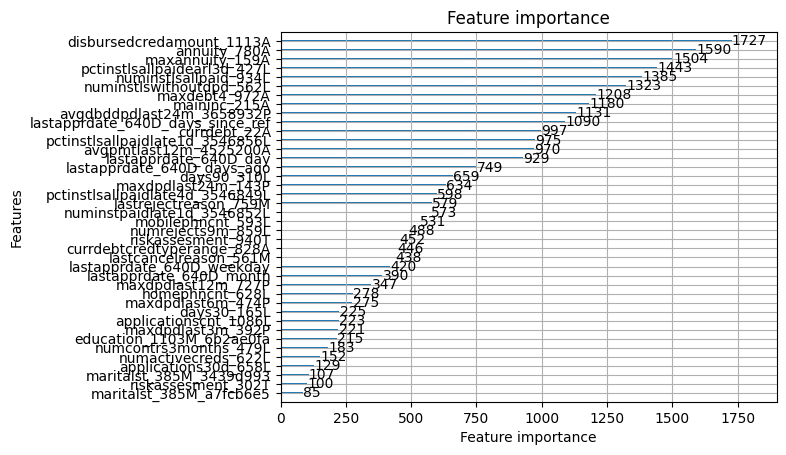

In [53]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=40)
plt.show()

### Balanceado

In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

model_smote = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    min_child_samples=20,
    min_split_gain=0.1
)
model_smote.fit(X_res, y_res)

y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_smote)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_smote = thresholds[np.argmax(f1_scores)]
y_pred_smote = (y_pred_proba_smote >= optimal_threshold_smote).astype(int)

print("=== Modelo Balanceado com SMOTE ===")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")
print(f"Threshold ótimo: {optimal_threshold_smote:.4f}")
print(classification_report(y_test, y_pred_smote))

[LightGBM] [Info] Number of positive: 232408, number of negative: 232408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11128
[LightGBM] [Info] Number of data points in the train set: 464816, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [55]:
import joblib

# Salvar o modelo treinado
joblib.dump(model_smote, 'model_smote.pkl')

['model_smote.pkl']